<a href="https://colab.research.google.com/github/zhus-dika/togyz-qumalaq-agent/blob/main/togyzqumalaq_aec_vs_random_policy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!python -m ipykernel install --user --name=venv

#  🐘 AEC environment https://pettingzoo.farama.org/api/aec/#about-aec

### 🐞 Imports

In [1]:
import gymnasium
import os
import numpy as np
from gymnasium.spaces import Discrete, MultiDiscrete
from gymnasium import spaces

from IPython.display import clear_output
import time
from pettingzoo import AECEnv
from pettingzoo.utils import agent_selector, wrappers
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import csv
import pandas as pd
from scipy.interpolate import interp1d

import os
from typing import Optional, Tuple

from torch.utils.tensorboard import SummaryWriter
from tianshou.utils import TensorboardLogger

import gymnasium
import numpy as np
import torch
from copy import deepcopy
from tianshou.data import Collector, VectorReplayBuffer
from tianshou.env import DummyVectorEnv
from tianshou.env.pettingzoo_env import PettingZooEnv
from tianshou.policy import BasePolicy, DQNPolicy, RainbowPolicy, MultiAgentPolicyManager, RandomPolicy
from tianshou.trainer import OffpolicyTrainer
from tianshou.utils.net.common import Net

import random
import copy

NUM_ITERS = 400
PLAYS = {"bastaushy": 0, "qostaushy": 0}

### 🦉 Create environment

In [2]:
def env(render_mode=None):
    """
    The env function often wraps the environment in wrappers by default.
    You can find full documentation for these methods
    elsewhere in the developer documentation.
    """
    internal_render_mode = render_mode if render_mode != "ansi" else "human"
    env = raw_env(render_mode=internal_render_mode)
    # This wrapper is only for environments which print results to the terminal
    if render_mode == "ansi":
        env = wrappers.CaptureStdoutWrapper(env)
    # this wrapper helps error handling for discrete action spaces
    env = wrappers.AssertOutOfBoundsWrapper(env)
    # Provides a wide vareity of helpful user errors
    # Strongly recommended
    env = wrappers.OrderEnforcingWrapper(env)
    return env


class raw_env(AECEnv):
    """
    The metadata holds environment constants. From gymnasium, we inherit the "render_modes",
    metadata which specifies which modes can be put into the render() method.
    At least human mode should be supported.
    The "name" metadata allows the environment to be pretty printed.
    """

    metadata = {
        "render_modes": ["ansi", "human"],
        "name": "togyzqumalaq_v0"
        }

    def __init__(self, render_mode=None):
        """
        The init method takes in environment arguments and
         should define the following attributes:
        - otaular
        - tuzdyq
        - qazandar
        - possible_agents
        - render_mode

        Note: as of v1.18.1, the action_spaces and observation_spaces attributes are deprecated.
        Spaces should be defined in the action_space() and observation_space() methods.
        If these methods are not overridden, spaces will be inferred from self.observation_spaces/action_spaces, raising a warning.

        These attributes should not be changed after initialization.
        """
        self.otaular = []
        self.tuzdyq = []
        self.qazandar = []
        self.direction = []
        self.agents = ["bastaushy", "qostaushy"]
        self.possible_agents = self.agents[:]
        # optional: we can define the observation and action spaces here as attributes to be used in their corresponding methods
        self.action_spaces = {i: spaces.Discrete(9) for i in self.agents}
        self.observation_spaces = {
            i: spaces.Dict(
                {
                    "observation": MultiDiscrete([100] * 18 + [9] * 2 + [82] * 2),
                    "action_mask": Discrete(9),
                }
            )
            for i in self.agents
        }
        self.render_mode = render_mode

    # Observation space should be defined here.
    def action_space(self, agent):
        return self.action_spaces[agent]

    # Action space should be defined here.
    def observation_space(self, agent):
        return self.observation_spaces[agent]

    def render(self):
        """
        Renders the environment. In human mode, it can print to terminal, open
        up a graphical window, or open up some other display that a human can see and understand.
        """
        """Renders the environment."""
        if self.render_mode is None:
            gymnasium.logger.warn(
                "You are calling render method without specifying any render mode."
            )
            return

        if len(self.agents) == 2:
            points_bastaushy_x = np.array([i * 2 for i in range(10)])
            points_bastaushy_y = np.array([i % 5 for i in range(50)])

            x = np.arange(-3, 225, 1)
            y = -1

            text_kwargs = dict(ha='center', va='center', fontsize=12)
            plt.figure(figsize=(17, 6))

            for i in range(9):
                # qostaushy's part
                plt.scatter(np.repeat(points_bastaushy_x + 25 * i, 5)[:self.otaular[17 - i]], points_bastaushy_y[:self.otaular[17 - i]], marker='o')
                # horizontal line
                plt.plot(x, np.repeat(y, len(x)))
                # vertical lines
                plt.plot(np.repeat(25 * i - 2, len(x)), np.arange(-7, 5, 12 / len(x)))
                # bastaushy's part
                plt.scatter(np.repeat(points_bastaushy_x + 25 * i, 5)[:self.otaular[i]], points_bastaushy_y[:self.otaular[i]] - 6, marker='o')

            #last vertical line
            plt.plot(np.repeat(25 * 9 - 2, len(x)), np.arange(-7, 5, 12 / len(x)))

            for i in range(9):
                # bastaushy's qumalaqtar
                plt.text(25 * i + 10, -7, f'{i} ({self.otaular[i]})', **text_kwargs)
                # qostaushy's qumalaqtar
                plt.text(25 * i + 10, 5, f'{17 - i} ({self.otaular[17 - i]})', **text_kwargs)
            # bastaushy qazan's qumalaqtar
            plt.text(230, -4, f'qazan: {self.qazandar[0]}', **text_kwargs)
            # qostaushy qazan's qumalaqtar
            plt.text(230, 2, f'qazan: {self.qazandar[1]}', **text_kwargs);
            # bastaushy tuzdyq's qumalaqtar
            plt.text(230, -6, f'tuzdyq: {self.tuzdyq[0]}', **text_kwargs)
            # qostaushy tuzdyq's qumalaqtar
            plt.text(230, 0, f'tuzdyq: {self.tuzdyq[1]}', **text_kwargs);
            plt.show()
        else:
            if self.render_mode == "human":
                print("Game over")
        time.sleep(2)
        clear_output(True)

    def _legal_moves(self, agent):
        cur_player = self.possible_agents.index(agent)
        opp_player = (cur_player + 1) % 2
        return [item for item in range(9 * cur_player, (cur_player + 1) * 9) if self.tuzdyq[opp_player] != item and self.otaular[item] > 0]

    def observe(self, agent):
        """
        Observe should return the observation of the specified agent. This function
        should return a sane observation (though not necessarily the most up to date possible)
        at any time after reset() is called.
        """
        # observation of one agent is the previous state of the other
        legal_moves = self._legal_moves(agent) if agent == self.agent_selection else []
        action_mask = np.zeros(9, "int8")
        if self.possible_agents.index(agent) == 1:
            legal_moves = [i - 9 for i in legal_moves]
        for i in legal_moves:
            action_mask[i] = 1
        observation = tuple(
            self.otaular + self.tuzdyq + self.qazandar
        )
        return {"observation": observation, "action_mask": action_mask}

    def close(self):
        """
        Close should release any graphical displays, subprocesses, network connections
        or any other environment data which should not be kept around after the
        user is no longer using the environment.
        """
        pass

    def reset(self, seed=None, options=None):
        """
        Reset needs to initialize the following attributes
        - agents
        - rewards
        - _cumulative_rewards
        - terminations
        - truncations
        - infos
        - agent_selection
        And must set up the environment so that render(), step(), and observe()
        can be called without issues.
        Here it sets up the state dictionary which is used by step() and the observations dictionary which is used by step() and observe()
        """
        self.agents = self.possible_agents[:]
        self.rewards = {agent: 0 for agent in self.agents}
        self._cumulative_rewards = {agent: 0 for agent in self.agents}
        self.otaular = [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
        self.direction = [list(range(18)), [9, 10, 11, 12, 13, 14, 15, 16, 17, 0, 1, 2, 3, 4, 5, 6, 7, 8]]
        self.tuzdyq = [-1, -1]
        self.qazandar = [0, 0]
        self.terminations = {agent: False for agent in self.agents}
        self.truncations = {agent: False for agent in self.agents}
        self.infos = {agent: {} for agent in self.agents}
        self.num_moves = 0
        observation = tuple(
            self.otaular + self.tuzdyq + self.qazandar
        )
        self.observations = {agent: observation for agent in self.agents}
        """
        Our agent_selector utility allows easy cyclic stepping through the agents list.
        """
        self._agent_selector = agent_selector(self.agents)
        self.agent_selection = self._agent_selector.next()

    def step(self, action):
        """
        step(action) takes in an action for the current agent (specified by
        agent_selection) and needs to update
        - rewards
        - _cumulative_rewards (accumulating the rewards)
        - terminations
        - truncations
        - infos
        - agent_selection (to the next agent)
        And any internal state used by observe() or render()
        """
        if (
            self.terminations[self.agent_selection]
            or self.truncations[self.agent_selection]
        ):
            # handles stepping an agent which is already dead
            # accepts a None action for the one agent, and moves the agent_selection to
            # the next dead agent,  or if there are no more dead agents, to the next live agent
            self._was_dead_step(action)
            return

        cur_player = self.possible_agents.index(self.agent_selection)
        opp_player = (cur_player + 1) % 2
        self.num_moves += 1
        if self.render_mode == "human":
            print(f'MOVE #{self.num_moves}')
        # The truncations dictionary must be updated for all players.
        self.truncations = {
            agent: self.num_moves >= NUM_ITERS for agent in self.agents
        }
        # distribute qumalaqs
        if cur_player == 1:
            action += 9
        if self.render_mode == "human":
            print(f'{self.agent_selection} made action {action}')
        num_qumalaq = self.otaular[action]
        idx_action = self.direction[cur_player].index(action)
        if self.otaular[action] == 1:
            self.otaular[self.direction[cur_player][idx_action + 1]] += 1
            self.otaular[action] -= 1
        else:
            i = 1
            while self.otaular[action] > 1:
                self.otaular[self.direction[cur_player][(idx_action + i) % 18]] += 1
                self.otaular[action] -= 1
                i += 1
        # check tuzdyq & add rewards to qazandar
        reward = 0
        # curriculum lesson # 6
        # increase reward for winning tuzdyq
        if self.check_tuzdyq(self.agent_selection, action):
            reward += 3
            #self.rewards[self.agent_selection] += 10
            if self.render_mode == "human":
                print(f'{self.agent_selection} won tuzdyq {reward}')
        else:

            if num_qumalaq > 1:
                last_otau = self.direction[cur_player][(idx_action + num_qumalaq - 1) % 18]
            else:
                last_otau = self.direction[cur_player][(idx_action + num_qumalaq) % 18]

            if last_otau in range(opp_player * 9, (opp_player + 1) * 9) and self.otaular[last_otau] % 2 == 0:
                reward += self.otaular[last_otau]
                if self.render_mode == "human":
                    print(f'{self.agent_selection} won {reward}')
                self.otaular[last_otau] = 0
            if self.tuzdyq[cur_player] >= 0 and self.otaular[self.tuzdyq[cur_player]] > 0:
                reward += self.otaular[self.tuzdyq[cur_player]]
                if self.render_mode == "human":
                    print(f'{self.agent_selection} won tuzdyq {self.otaular[self.tuzdyq[cur_player]]}')
                self.otaular[self.tuzdyq[cur_player]] = 0
        if self.render_mode == "human":
            print(f'{self.agent_selection} won total {reward}')
        self.qazandar[cur_player] += reward
        #=======================================================================#
        # curriculum lesson # 1
        # for i in range(cur_player * 9, 9 + cur_player * 9):
        #     if self.otaular[i] % 2 != 0:
        #         reward -= 1
        
        #=======================================================================#
        # curriculum lesson # 2
        opp_actions = self._legal_moves(self.possible_agents[opp_player])
        rew_opp = 0
        for opp_act in opp_actions:
            num_qumalaq = self.otaular[opp_act]
            idx_action = self.direction[opp_player].index(action)
            if num_qumalaq > 1:
                last_otau = self.direction[opp_player][(idx_action + num_qumalaq - 1) % 18]
            else:
                last_otau = self.direction[opp_player][(idx_action + num_qumalaq) % 18]
            if rew_opp < self.otaular[last_otau] and self.otaular[last_otau] % 2 == 1 and last_otau in range(cur_player * 9, (cur_player + 1) * 9):
                rew_opp = self.otaular[last_otau]
        self.rewards[self.agent_selection] -= 0.5 * rew_opp
        #=======================================================================#
        # curriculum lesson # 3
        # reduce the number of steps
        self.rewards[self.agent_selection] -= 1
        
        self.rewards[self.agent_selection] += reward
        # check if there is a winner
        winner = self.check_for_winner()

        #=======================================================================#
        # curriculum lesson # 4
        # increase reward for winning the game

        #=======================================================================#
        # curriculum lesson # 5
        # calculate reward in other way
        # self.rewards[self.agent_selection] += (self.qazandar[cur_player] - self.qazandar[opp_player]) / 82
        # self.rewards[self.agent_selection] -= 0.05
        if winner:
            # print("NSTEPS =", self.num_moves)
            self.rewards[self.agent_selection] += 100
            # self.rewards[self.agent_selection] += 1
            self.terminations = {i: True for i in self.agents}
            if self.render_mode == "human":
                print(f'{self.agent_selection} won the game!!!')
        # selects the next agent.
        self.agent_selection = self._agent_selector.next()
        # Adds .rewards to ._cumulative_rewards
        self._accumulate_rewards()

        if self.render_mode == "human":
            self.render()

    def check_tuzdyq(self, agent, action):
        cur_player = self.possible_agents.index(agent)
        opp_player = (cur_player + 1) % 2
        idx = self.direction[cur_player].index(action)
        num_qumalaq = self.otaular[action]

        if num_qumalaq > 1:
            last_otau = self.direction[cur_player][(idx + num_qumalaq - 1) % 18]
        else:
            last_otau = self.direction[cur_player][(idx + num_qumalaq) % 18]

        if last_otau in range(opp_player * 9, (opp_player + 1) * 9) and self.otaular[last_otau] == 3 and last_otau != 17 - cur_player * 9 and abs(last_otau - self.tuzdyq[opp_player]) != 9:
            self.tuzdyq[cur_player] = last_otau
            self.otaular[last_otau] = 0
            if self.render_mode == "human":
                print(f'{agent} got tuzdyq {last_otau}!')
            return True

        return False

    def check_atsyrau(self, agent):
        cur_player = self.possible_agents.index(agent)
        opp_player = (cur_player + 1) % 2

        for idx, i in enumerate(self.otaular[cur_player * 9: (cur_player + 1) * 9]):
            if i > 0 and idx + cur_player * 9 != self.tuzdyq[opp_player]:
                return False
        if self.render_mode == "human":
            print(f'{agent} reached atsyrau')
        return True

    def check_for_winner(self):
        cur_player = self.possible_agents.index(self.agent_selection)
        opp_player = (cur_player + 1) % 2
        if self.qazandar[cur_player] > 81:
            PLAYS[self.agent_selection] += 1
            return True
        if self.check_atsyrau(self.possible_agents[opp_player]) and self.qazandar[opp_player] <= 81:
            PLAYS[self.agent_selection] += 1
            return True
        return False

### 🦚 Testing environment

In [ ]:
# env = env(render_mode="human")
# env.reset(seed=42)

# for agent in env.agent_iter():
#     observation, reward, termination, truncation, info = env.last()

#     if termination or truncation:
#         action = None
#     else:
#         mask = observation["action_mask"]
#         # this is where you would insert your policy
#         action = env.action_space(agent).sample(mask)

#     env.step(action)
# env.close()

# 🐼 DQN agent to play vs a random policy agent https://pettingzoo.farama.org/tutorials/tianshou/intermediate/

### 🐝 Imports

In [3]:
import os
from typing import Optional, Tuple

from torch.utils.tensorboard import SummaryWriter
from tianshou.utils import TensorboardLogger

import gymnasium
import numpy as np
import torch
from copy import deepcopy
from tianshou.data import Collector, VectorReplayBuffer
from tianshou.env import DummyVectorEnv
from tianshou.env.pettingzoo_env import PettingZooEnv
from tianshou.policy import BasePolicy, DQNPolicy, RainbowPolicy, MultiAgentPolicyManager, RandomPolicy
from tianshou.trainer import OffpolicyTrainer
from tianshou.utils.net.common import Net

### 🐫 Prepare main functions

In [5]:
def _get_agents_dqn(
    agent_learn: Optional[BasePolicy] = None,
    agent_opponent: Optional[BasePolicy] = None,
    optim: Optional[torch.optim.Optimizer] = None,
) -> Tuple[BasePolicy, torch.optim.Optimizer, list]:
    env = _get_env()
    observation_space = (
        env.observation_space["observation"]
        if isinstance(env.observation_space, gymnasium.spaces.Dict)
        else env.observation_space
    )
    if agent_learn is None:
        # model
        net = Net(
            state_shape=observation_space.shape or observation_space.n,
            action_shape=env.action_space.shape or env.action_space.n,
            hidden_sizes=[256, 512, 512, 256],
            #hidden_sizes=[1024, 2048, 2048, 1024],
            device="cuda" if torch.cuda.is_available() else "cpu",
        ).to("cuda" if torch.cuda.is_available() else "cpu")

        if optim is None:
            optim = torch.optim.Adam(net.parameters(), lr=1e-4)
        agent_learn = DQNPolicy(
            model=net,
            optim=optim,
            discount_factor=0.9,
            estimation_step=3,
            target_update_freq=320,
            action_space=env.action_space
        ).to("cuda" if torch.cuda.is_available() else "cpu")


    if agent_opponent is None:
        agent_opponent = RandomPolicy(action_space=env.action_space)

    agents = [agent_opponent, agent_learn]
    #agents = [agent_learn, agent_opponent]
    policy = MultiAgentPolicyManager(policies=agents, env=env)
    return policy, optim, env.agents


def _get_env(render_mode=None):
    """This function is needed to provide callables for DummyVectorEnv."""
    def env(render_mode=None):
        """
        The env function often wraps the environment in wrappers by default.
        You can find full documentation for these methods
        elsewhere in the developer documentation.
        """
        internal_render_mode = render_mode if render_mode != "ansi" else "human"
        env = raw_env(render_mode=internal_render_mode)
        # This wrapper is only for environments which print results to the terminal
        if render_mode == "ansi":
            env = wrappers.CaptureStdoutWrapper(env)
        # this wrapper helps error handling for discrete action spaces
        env = wrappers.AssertOutOfBoundsWrapper(env)
        # Provides a wide vareity of helpful user errors
        # Strongly recommended
        env = wrappers.OrderEnforcingWrapper(env)
        return env
    return PettingZooEnv(env(render_mode=render_mode))

### 🐎 Load trained agents

In [6]:
agent1_path = "models/qostaushy/policy_128x256x256x128_bs64.pth"
agent2_path = "models/qostaushy/policy_256x512x512x256_bs128.pth"
agent3_path = "models/qostaushy/policy_512x1024x1024x512_bs128.pth"
agent4_path = "models/qostaushy/policy_128x256x512x256x128_trained_128x256x256x128.pth"

agents_learned_qostaushy = []
env = _get_env()
net1 = Net(
            state_shape=(22,),
            action_shape=env.action_space.shape or env.action_space.n,
            hidden_sizes=[128, 256, 256, 128],
            device="cuda" if torch.cuda.is_available() else "cpu",
        ).to("cuda" if torch.cuda.is_available() else "cpu")

agent1_learned = DQNPolicy(
            model=net1,
            optim = torch.optim.Adam(net1.parameters(), lr=1e-4),
            discount_factor=0.9,
            estimation_step=3,
            target_update_freq=320,
            action_space=env.action_space
        ).to("cuda" if torch.cuda.is_available() else "cpu")

agent1_learned.load_state_dict(torch.load(agent1_path))
agents_learned_qostaushy.append(agent1_learned)


net2 = Net(
            state_shape=(22,),
            action_shape=env.action_space.shape or env.action_space.n,
            hidden_sizes=[256, 512, 512, 256],
            device="cuda" if torch.cuda.is_available() else "cpu",
        ).to("cuda" if torch.cuda.is_available() else "cpu")

agent2_learned = DQNPolicy(
            model=net2,
            optim = torch.optim.Adam(net1.parameters(), lr=1e-4),
            discount_factor=0.9,
            estimation_step=3,
            target_update_freq=320,
            action_space=env.action_space
        ).to("cuda" if torch.cuda.is_available() else "cpu")
agent2_learned.load_state_dict(torch.load(agent2_path))
agents_learned_qostaushy.append(agent2_learned)


net3 = Net(
            state_shape=(22,),
            action_shape=env.action_space.shape or env.action_space.n,
            hidden_sizes=[512, 1024, 1024, 512],
            device="cuda" if torch.cuda.is_available() else "cpu",
        ).to("cuda" if torch.cuda.is_available() else "cpu")

agent3_learned = DQNPolicy(
            model=net3,
            optim = torch.optim.Adam(net3.parameters(), lr=1e-4),
            discount_factor=0.9,
            estimation_step=3,
            target_update_freq=320,
            action_space=env.action_space
        ).to("cuda" if torch.cuda.is_available() else "cpu")
agent3_learned.load_state_dict(torch.load(agent3_path))
agents_learned_qostaushy.append(agent3_learned)


net4 = Net(
            state_shape=(22,),
            action_shape=env.action_space.shape or env.action_space.n,
            hidden_sizes=[128, 256, 512, 256, 128],
            device="cuda" if torch.cuda.is_available() else "cpu",
        ).to("cuda" if torch.cuda.is_available() else "cpu")

agent4_learned = DQNPolicy(
            model=net4,
            optim = torch.optim.Adam(net3.parameters(), lr=1e-4),
            discount_factor=0.9,
            estimation_step=3,
            target_update_freq=320,
            action_space=env.action_space
        ).to("cuda" if torch.cuda.is_available() else "cpu")

agent4_learned.load_state_dict(torch.load(agent4_path))
agents_learned_qostaushy.append(agent4_learned)

### 🐦 Add logger (to run tensorboard type in terminal  $tensorboard --logdir logs/dqn)

In [24]:
log_path = os.path.join('logs', "dqn")
writer = SummaryWriter(log_path)
logger = TensorboardLogger(writer)

###  🐑 Training code https://tianshou.org/en/stable/01_tutorials/04_tictactoe.html

In [10]:
# Before evaluate this cell run the cell with env
# ======== Step 1: Environment setup =========
train_envs = DummyVectorEnv([_get_env for _ in range(100)])
test_envs = DummyVectorEnv([_get_env for _ in range(100)])

# seed
seed = 11
np.random.seed(seed)
torch.manual_seed(seed)
train_envs.seed(seed)
test_envs.seed(seed)

# ======== Step 2: Agent setup =========
policy, optim, agents = _get_agents_dqn(agent_opponent=agents_learned_qostaushy[1])

# # ======== Step 3: Collector setup =========
train_collector = Collector(
    policy,
    train_envs,
    VectorReplayBuffer(20_000, len(train_envs)),
    exploration_noise=True,
)
test_collector = Collector(policy, test_envs, exploration_noise=True)
# policy.set_eps(1)

# ======== Step 4: Callback functions setup =========
def save_best_fn(policy):
    model_save_path = os.path.join("models", "dqn", "policy.pth")
    os.makedirs(os.path.join("models", "dqn"), exist_ok=True)
    torch.save(policy.policies[agents[1]].state_dict(), model_save_path)

def stop_fn(mean_rewards):
    return mean_rewards >= 21000

def train_fn(epoch, env_step):
    policy.policies[agents[1]].set_eps(0.1)

def test_fn(epoch, env_step):
    policy.policies[agents[1]].set_eps(0.05)

def reward_metric(rews):
    return rews[:, 1]

# ======== Step 5: Run the trainer =========
result = OffpolicyTrainer(
    policy=policy,
    train_collector=train_collector,
    test_collector=test_collector,
    max_epoch=150,
    step_per_epoch=1000,
    step_per_collect=50,
    episode_per_test=10,
    batch_size=256,
    train_fn=train_fn,
    test_fn=test_fn,
    stop_fn=stop_fn,
    #save_best_fn=save_best_fn,
    update_per_step=0.1,
    test_in_train=False,
    reward_metric=reward_metric,
    verbose=True,
    logger=logger
).run()

# return result, policy.policies[agents[1]]
print(f"\n==========Result==========\n{result}")
print("\n(the trained policy can be accessed via policy.policies[agents[1]])")

Epoch #1: 1001it [00:01, 589.44it/s, env_step=1000, gradient_step=100, len=0, n/ep=0, n/st=100, rew=0.00]                                                                                         


Epoch #1: test_reward: 2097.800000 ± 1347.820300, best_reward: 9861.500000 ± 4343.065674 in #0


Epoch #2: 1001it [00:01, 663.36it/s, env_step=2000, gradient_step=200, len=0, n/ep=0, n/st=100, rew=0.00]                                                                                         


Epoch #2: test_reward: 5318.400000 ± 2945.467134, best_reward: 9861.500000 ± 4343.065674 in #0


Epoch #3: 1001it [00:01, 553.04it/s, env_step=3000, gradient_step=300, len=0, n/ep=0, n/st=100, rew=0.00]                                                                                         


Epoch #3: test_reward: 6871.200000 ± 2056.227069, best_reward: 9861.500000 ± 4343.065674 in #0


Epoch #4: 1001it [00:01, 766.53it/s, env_step=4000, gradient_step=400, len=0, n/ep=0, n/st=100, rew=0.00]                                                                                         


Epoch #4: test_reward: 8682.200000 ± 5708.286359, best_reward: 9861.500000 ± 4343.065674 in #0


Epoch #5: 1001it [00:01, 642.65it/s, env_step=5000, gradient_step=500, len=0, n/ep=0, n/st=100, rew=0.00]                                                                                         


Epoch #5: test_reward: 8555.200000 ± 2260.999284, best_reward: 9861.500000 ± 4343.065674 in #0


Epoch #6: 1001it [00:01, 650.78it/s, env_step=6000, gradient_step=600, len=0, n/ep=0, n/st=100, rew=0.00]                                                                                         


Epoch #6: test_reward: 10723.000000 ± 2977.142019, best_reward: 10723.000000 ± 2977.142019 in #6


Epoch #7: 1001it [00:01, 565.71it/s, env_step=7000, gradient_step=700, len=68, n/ep=0, n/st=100, rew=1775.00]                                                                                     


Epoch #7: test_reward: 6037.600000 ± 3431.431398, best_reward: 10723.000000 ± 2977.142019 in #6


Epoch #8: 1001it [00:01, 623.63it/s, env_step=8000, gradient_step=800, len=80, n/ep=1, n/st=100, rew=2518.00]                                                                                     


Epoch #8: test_reward: 7393.400000 ± 2375.054703, best_reward: 10723.000000 ± 2977.142019 in #6


Epoch #9: 1001it [00:02, 383.68it/s, env_step=9000, gradient_step=900, len=90, n/ep=1, n/st=100, rew=2765.00]                                                                                     


Epoch #9: test_reward: 10779.600000 ± 3509.502392, best_reward: 10779.600000 ± 3509.502392 in #9


Epoch #10: 1001it [00:01, 579.32it/s, env_step=10000, gradient_step=1000, len=90, n/ep=0, n/st=100, rew=2765.00]                                                                                  


Epoch #10: test_reward: 13421.000000 ± 3428.786549, best_reward: 13421.000000 ± 3428.786549 in #10


Epoch #11: 1001it [00:01, 587.18it/s, env_step=11000, gradient_step=1100, len=110, n/ep=1, n/st=100, rew=3780.00]                                                                                 


Epoch #11: test_reward: 12205.400000 ± 5979.719462, best_reward: 13421.000000 ± 3428.786549 in #10


Epoch #12: 1001it [00:01, 533.12it/s, env_step=12000, gradient_step=1200, len=116, n/ep=0, n/st=100, rew=3617.00]                                                                                 


Epoch #12: test_reward: 11463.600000 ± 4461.561502, best_reward: 13421.000000 ± 3428.786549 in #10


Epoch #13: 1001it [00:02, 427.68it/s, env_step=13000, gradient_step=1300, len=130, n/ep=1, n/st=100, rew=4758.00]                                                                                 


Epoch #13: test_reward: 11203.200000 ± 4163.058799, best_reward: 13421.000000 ± 3428.786549 in #10


Epoch #14: 1001it [00:02, 435.05it/s, env_step=14000, gradient_step=1400, len=130, n/ep=0, n/st=100, rew=4758.00]                                                                                 


Epoch #14: test_reward: 10250.200000 ± 3027.343152, best_reward: 13421.000000 ± 3428.786549 in #10


Epoch #15: 1001it [00:01, 594.52it/s, env_step=15000, gradient_step=1500, len=141, n/ep=0, n/st=100, rew=6296.00]                                                                                 


Epoch #15: test_reward: 11093.500000 ± 3868.824143, best_reward: 13421.000000 ± 3428.786549 in #10


Epoch #16: 1001it [00:01, 562.52it/s, env_step=16000, gradient_step=1600, len=154, n/ep=0, n/st=100, rew=5305.00]                                                                                 


Epoch #16: test_reward: 7044.800000 ± 3366.162468, best_reward: 13421.000000 ± 3428.786549 in #10


Epoch #17: 1001it [00:02, 459.43it/s, env_step=17000, gradient_step=1700, len=169, n/ep=0, n/st=100, rew=6461.00]                                                                                 


Epoch #17: test_reward: 12391.600000 ± 3288.409409, best_reward: 13421.000000 ± 3428.786549 in #10


Epoch #18: 1001it [00:02, 493.89it/s, env_step=18000, gradient_step=1800, len=179, n/ep=0, n/st=100, rew=7357.00]                                                                                 


Epoch #18: test_reward: 10590.200000 ± 3658.735705, best_reward: 13421.000000 ± 3428.786549 in #10


Epoch #19: 1001it [00:02, 442.00it/s, env_step=19000, gradient_step=1900, len=190, n/ep=2, n/st=100, rew=8469.00]                                                                                 


Epoch #19: test_reward: 10188.000000 ± 2123.302145, best_reward: 13421.000000 ± 3428.786549 in #10


Epoch #20: 1001it [00:01, 573.00it/s, env_step=20000, gradient_step=2000, len=197, n/ep=0, n/st=100, rew=7840.50]                                                                                 


Epoch #20: test_reward: 11272.400000 ± 3005.872892, best_reward: 13421.000000 ± 3428.786549 in #10


Epoch #21: 1001it [00:01, 512.23it/s, env_step=21000, gradient_step=2100, len=210, n/ep=1, n/st=100, rew=8332.00]                                                                                 


Epoch #21: test_reward: 10301.200000 ± 2537.792931, best_reward: 13421.000000 ± 3428.786549 in #10


Epoch #22: 1001it [00:02, 463.59it/s, env_step=22000, gradient_step=2200, len=218, n/ep=0, n/st=100, rew=10792.00]                                                                                


Epoch #22: test_reward: 9382.200000 ± 4134.963623, best_reward: 13421.000000 ± 3428.786549 in #10


Epoch #23: 1001it [00:02, 471.92it/s, env_step=23000, gradient_step=2300, len=228, n/ep=0, n/st=100, rew=11571.50]                                                                                


Epoch #23: test_reward: 10822.400000 ± 5712.217069, best_reward: 13421.000000 ± 3428.786549 in #10


Epoch #24: 1001it [00:01, 592.71it/s, env_step=24000, gradient_step=2400, len=240, n/ep=2, n/st=100, rew=12205.50]                                                                                


Epoch #24: test_reward: 16745.400000 ± 5316.471390, best_reward: 16745.400000 ± 5316.471390 in #24


Epoch #25: 1001it [00:01, 501.60it/s, env_step=25000, gradient_step=2500, len=68, n/ep=0, n/st=100, rew=2434.00]                                                                                  


Epoch #25: test_reward: 9863.600000 ± 2591.755667, best_reward: 16745.400000 ± 5316.471390 in #24


Epoch #26: 1001it [00:02, 420.15it/s, env_step=26000, gradient_step=2600, len=253, n/ep=0, n/st=100, rew=10360.00]                                                                                


Epoch #26: test_reward: 14900.500000 ± 3399.339973, best_reward: 16745.400000 ± 5316.471390 in #24


Epoch #27: 1001it [00:01, 519.28it/s, env_step=27000, gradient_step=2700, len=267, n/ep=0, n/st=100, rew=12099.75]                                                                                


Epoch #27: test_reward: 6826.800000 ± 1743.257686, best_reward: 16745.400000 ± 5316.471390 in #24


Epoch #28: 1001it [00:01, 514.14it/s, env_step=28000, gradient_step=2800, len=280, n/ep=2, n/st=100, rew=13034.50]                                                                                


Epoch #28: test_reward: 14420.900000 ± 5741.968625, best_reward: 16745.400000 ± 5316.471390 in #24


Epoch #29: 1001it [00:02, 420.05it/s, env_step=29000, gradient_step=2900, len=135, n/ep=0, n/st=100, rew=6219.00]                                                                                 


Epoch #29: test_reward: 6704.000000 ± 2339.751611, best_reward: 16745.400000 ± 5316.471390 in #24


Epoch #30: 1001it [00:02, 415.85it/s, env_step=30000, gradient_step=3000, len=299, n/ep=0, n/st=100, rew=12759.00]                                                                                


Epoch #30: test_reward: 11965.800000 ± 4163.381361, best_reward: 16745.400000 ± 5316.471390 in #24


Epoch #31: 1001it [00:02, 492.86it/s, env_step=31000, gradient_step=3100, len=145, n/ep=0, n/st=100, rew=5030.00]                                                                                 


Epoch #31: test_reward: 9117.200000 ± 2278.505510, best_reward: 16745.400000 ± 5316.471390 in #24


Epoch #32: 1001it [00:02, 479.00it/s, env_step=32000, gradient_step=3200, len=320, n/ep=2, n/st=100, rew=14816.25]                                                                                


Epoch #32: test_reward: 7533.100000 ± 2696.711125, best_reward: 16745.400000 ± 5316.471390 in #24


Epoch #33: 1001it [00:02, 480.81it/s, env_step=33000, gradient_step=3300, len=329, n/ep=0, n/st=100, rew=15561.50]                                                                                


Epoch #33: test_reward: 11941.400000 ± 5074.441688, best_reward: 16745.400000 ± 5316.471390 in #24


Epoch #34: 1001it [00:02, 452.68it/s, env_step=34000, gradient_step=3400, len=339, n/ep=0, n/st=100, rew=13934.50]                                                                                


Epoch #34: test_reward: 14039.300000 ± 4640.984207, best_reward: 16745.400000 ± 5316.471390 in #24


Epoch #35: 1001it [00:02, 419.68it/s, env_step=35000, gradient_step=3500, len=137, n/ep=0, n/st=100, rew=6293.00]                                                                                 


Epoch #35: test_reward: 9446.400000 ± 2934.930704, best_reward: 16745.400000 ± 5316.471390 in #24


Epoch #36: 1001it [00:02, 450.88it/s, env_step=36000, gradient_step=3600, len=249, n/ep=0, n/st=100, rew=9384.50]                                                                                 


Epoch #36: test_reward: 10507.400000 ± 2444.260878, best_reward: 16745.400000 ± 5316.471390 in #24


Epoch #37: 1001it [00:01, 507.15it/s, env_step=37000, gradient_step=3700, len=104, n/ep=0, n/st=100, rew=3756.00]                                                                                 


Epoch #37: test_reward: 12404.000000 ± 3851.823776, best_reward: 16745.400000 ± 5316.471390 in #24


Epoch #38: 1001it [00:01, 571.55it/s, env_step=38000, gradient_step=3800, len=187, n/ep=0, n/st=100, rew=8359.00]                                                                                 


Epoch #38: test_reward: 8938.800000 ± 4177.617307, best_reward: 16745.400000 ± 5316.471390 in #24


Epoch #39: 1001it [00:01, 513.48it/s, env_step=39000, gradient_step=3900, len=194, n/ep=0, n/st=100, rew=8822.00]                                                                                 


Epoch #39: test_reward: 9065.400000 ± 3521.607139, best_reward: 16745.400000 ± 5316.471390 in #24


Epoch #40: 1001it [00:01, 516.15it/s, env_step=40000, gradient_step=4000, len=400, n/ep=2, n/st=100, rew=19027.25]                                                                                


Epoch #40: test_reward: 7071.600000 ± 3839.324295, best_reward: 16745.400000 ± 5316.471390 in #24


Epoch #41: 1001it [00:01, 511.35it/s, env_step=41000, gradient_step=4100, len=219, n/ep=0, n/st=100, rew=10347.00]                                                                                


Epoch #41: test_reward: 8248.600000 ± 2965.138520, best_reward: 16745.400000 ± 5316.471390 in #24


Epoch #42: 1001it [00:02, 472.19it/s, env_step=42000, gradient_step=4200, len=219, n/ep=0, n/st=100, rew=10347.00]                                                                                


Epoch #42: test_reward: 12346.400000 ± 3253.680353, best_reward: 16745.400000 ± 5316.471390 in #24


Epoch #43: 1001it [00:01, 519.16it/s, env_step=43000, gradient_step=4300, len=185, n/ep=1, n/st=100, rew=7136.50]                                                                                 


Epoch #43: test_reward: 11356.900000 ± 4158.769925, best_reward: 16745.400000 ± 5316.471390 in #24


Epoch #44: 1001it [00:02, 412.31it/s, env_step=44000, gradient_step=4400, len=185, n/ep=0, n/st=100, rew=7136.50]                                                                                 


Epoch #44: test_reward: 14929.700000 ± 5775.752662, best_reward: 16745.400000 ± 5316.471390 in #24


Epoch #45: 1001it [00:02, 449.65it/s, env_step=45000, gradient_step=4500, len=217, n/ep=1, n/st=100, rew=9852.00]                                                                                 


Epoch #45: test_reward: 12150.800000 ± 4728.750803, best_reward: 16745.400000 ± 5316.471390 in #24


Epoch #46: 1001it [00:02, 352.68it/s, env_step=46000, gradient_step=4600, len=147, n/ep=1, n/st=100, rew=7655.00]                                                                                 


Epoch #46: test_reward: 14693.400000 ± 4366.976350, best_reward: 16745.400000 ± 5316.471390 in #24


Epoch #47: 1001it [00:02, 417.79it/s, env_step=47000, gradient_step=4700, len=137, n/ep=1, n/st=100, rew=6758.50]                                                                                 


Epoch #47: test_reward: 9794.800000 ± 5034.523390, best_reward: 16745.400000 ± 5316.471390 in #24


Epoch #48: 1001it [00:02, 445.32it/s, env_step=48000, gradient_step=4800, len=135, n/ep=1, n/st=100, rew=6135.50]                                                                                 


Epoch #48: test_reward: 10686.400000 ± 5009.785129, best_reward: 16745.400000 ± 5316.471390 in #24


Epoch #49: 1001it [00:02, 420.36it/s, env_step=49000, gradient_step=4900, len=211, n/ep=0, n/st=100, rew=9902.00]                                                                                 


Epoch #49: test_reward: 11677.500000 ± 2720.854838, best_reward: 16745.400000 ± 5316.471390 in #24


Epoch #50: 1001it [00:02, 444.11it/s, env_step=50000, gradient_step=5000, len=237, n/ep=0, n/st=100, rew=10910.00]                                                                                


Epoch #50: test_reward: 12051.400000 ± 3880.339552, best_reward: 16745.400000 ± 5316.471390 in #24


Epoch #51: 1001it [00:02, 494.77it/s, env_step=51000, gradient_step=5100, len=265, n/ep=0, n/st=100, rew=14016.00]                                                                                


Epoch #51: test_reward: 10412.600000 ± 3677.070143, best_reward: 16745.400000 ± 5316.471390 in #24


Epoch #52: 1001it [00:02, 477.25it/s, env_step=52000, gradient_step=5200, len=400, n/ep=0, n/st=100, rew=19488.00]                                                                                


Epoch #52: test_reward: 15945.300000 ± 5990.846736, best_reward: 16745.400000 ± 5316.471390 in #24


Epoch #53: 1001it [00:02, 470.65it/s, env_step=53000, gradient_step=5300, len=281, n/ep=0, n/st=100, rew=13525.50]                                                                                


Epoch #53: test_reward: 12344.800000 ± 3535.409391, best_reward: 16745.400000 ± 5316.471390 in #24


Epoch #54: 1001it [00:02, 491.80it/s, env_step=54000, gradient_step=5400, len=343, n/ep=0, n/st=100, rew=18542.00]                                                                                


Epoch #54: test_reward: 15537.400000 ± 4975.753213, best_reward: 16745.400000 ± 5316.471390 in #24


Epoch #55: 1001it [00:02, 400.82it/s, env_step=55000, gradient_step=5500, len=186, n/ep=0, n/st=100, rew=9846.50]                                                                                 


Epoch #55: test_reward: 14738.500000 ± 4890.353837, best_reward: 16745.400000 ± 5316.471390 in #24


Epoch #56: 1001it [00:02, 375.35it/s, env_step=56000, gradient_step=5600, len=277, n/ep=0, n/st=100, rew=12784.50]                                                                                


Epoch #56: test_reward: 14330.800000 ± 4930.103545, best_reward: 16745.400000 ± 5316.471390 in #24


Epoch #57: 1001it [00:02, 484.99it/s, env_step=57000, gradient_step=5700, len=322, n/ep=0, n/st=100, rew=16304.00]                                                                                


Epoch #57: test_reward: 12881.600000 ± 3688.288036, best_reward: 16745.400000 ± 5316.471390 in #24


Epoch #58: 1001it [00:02, 400.08it/s, env_step=58000, gradient_step=5800, len=262, n/ep=0, n/st=100, rew=14744.00]                                                                                


Epoch #58: test_reward: 13175.200000 ± 5935.919353, best_reward: 16745.400000 ± 5316.471390 in #24


Epoch #59: 1001it [00:02, 431.42it/s, env_step=59000, gradient_step=5900, len=255, n/ep=0, n/st=100, rew=15222.00]                                                                                


Epoch #59: test_reward: 14750.700000 ± 3863.203957, best_reward: 16745.400000 ± 5316.471390 in #24


Epoch #60: 1001it [00:02, 478.26it/s, env_step=60000, gradient_step=6000, len=96, n/ep=1, n/st=100, rew=3345.50]                                                                                  


Epoch #60: test_reward: 19623.300000 ± 4957.901614, best_reward: 19623.300000 ± 4957.901614 in #60


Epoch #61: 1001it [00:01, 507.55it/s, env_step=61000, gradient_step=6100, len=319, n/ep=0, n/st=100, rew=16394.00]                                                                                


Epoch #61: test_reward: 9442.900000 ± 5369.656292, best_reward: 19623.300000 ± 4957.901614 in #60


Epoch #62: 1001it [00:02, 418.28it/s, env_step=62000, gradient_step=6200, len=314, n/ep=0, n/st=100, rew=14372.00]                                                                                


Epoch #62: test_reward: 8075.700000 ± 4516.606471, best_reward: 19623.300000 ± 4957.901614 in #60


Epoch #63: 1001it [00:02, 447.52it/s, env_step=63000, gradient_step=6300, len=309, n/ep=0, n/st=100, rew=13975.50]                                                                                


Epoch #63: test_reward: 14565.900000 ± 5571.961099, best_reward: 19623.300000 ± 4957.901614 in #60


Epoch #64: 1001it [00:02, 498.93it/s, env_step=64000, gradient_step=6400, len=357, n/ep=0, n/st=100, rew=18181.00]                                                                                


Epoch #64: test_reward: 12596.000000 ± 6277.039159, best_reward: 19623.300000 ± 4957.901614 in #60


Epoch #65: 1001it [00:02, 487.96it/s, env_step=65000, gradient_step=6500, len=226, n/ep=2, n/st=100, rew=10999.25]                                                                                


Epoch #65: test_reward: 7868.000000 ± 3554.988608, best_reward: 19623.300000 ± 4957.901614 in #60


Epoch #66: 1001it [00:01, 516.97it/s, env_step=66000, gradient_step=6600, len=261, n/ep=0, n/st=100, rew=9170.50]                                                                                 


Epoch #66: test_reward: 17072.100000 ± 5990.674694, best_reward: 19623.300000 ± 4957.901614 in #60


Epoch #67: 1001it [00:01, 531.86it/s, env_step=67000, gradient_step=6700, len=352, n/ep=1, n/st=100, rew=20961.50]                                                                                


Epoch #67: test_reward: 18926.900000 ± 3734.039862, best_reward: 19623.300000 ± 4957.901614 in #60


Epoch #68: 1001it [00:01, 516.83it/s, env_step=68000, gradient_step=6800, len=179, n/ep=0, n/st=100, rew=7688.00]                                                                                 


Epoch #68: test_reward: 19187.200000 ± 4721.721313, best_reward: 19623.300000 ± 4957.901614 in #60


Epoch #69: 1001it [00:02, 473.49it/s, env_step=69000, gradient_step=6900, len=288, n/ep=0, n/st=100, rew=15947.50]                                                                                


Epoch #69: test_reward: 14244.400000 ± 5213.183791, best_reward: 19623.300000 ± 4957.901614 in #60


Epoch #70: 1001it [00:02, 468.51it/s, env_step=70000, gradient_step=7000, len=398, n/ep=1, n/st=100, rew=21660.50]                                                                                


Epoch #70: test_reward: 20667.800000 ± 2776.324253, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #71: 1001it [00:02, 456.60it/s, env_step=71000, gradient_step=7100, len=202, n/ep=0, n/st=100, rew=8701.50]                                                                                 


Epoch #71: test_reward: 12039.100000 ± 3889.472932, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #72: 1001it [00:01, 543.05it/s, env_step=72000, gradient_step=7200, len=275, n/ep=1, n/st=100, rew=13771.00]                                                                                


Epoch #72: test_reward: 13127.400000 ± 4926.304583, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #73: 1001it [00:02, 424.71it/s, env_step=73000, gradient_step=7300, len=159, n/ep=1, n/st=100, rew=8823.00]                                                                                 


Epoch #73: test_reward: 11788.000000 ± 6016.785703, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #74: 1001it [00:01, 548.36it/s, env_step=74000, gradient_step=7400, len=270, n/ep=1, n/st=100, rew=12827.00]                                                                                


Epoch #74: test_reward: 12131.400000 ± 5940.048959, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #75: 1001it [00:02, 489.78it/s, env_step=75000, gradient_step=7500, len=297, n/ep=1, n/st=100, rew=15931.00]                                                                                


Epoch #75: test_reward: 14851.400000 ± 5514.096992, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #76: 1001it [00:02, 439.20it/s, env_step=76000, gradient_step=7600, len=298, n/ep=0, n/st=100, rew=15814.50]                                                                                


Epoch #76: test_reward: 12277.100000 ± 6040.890935, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #77: 1001it [00:02, 423.61it/s, env_step=77000, gradient_step=7700, len=400, n/ep=0, n/st=100, rew=18010.50]                                                                                


Epoch #77: test_reward: 16660.700000 ± 5917.946165, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #78: 1001it [00:01, 535.95it/s, env_step=78000, gradient_step=7800, len=147, n/ep=0, n/st=100, rew=6119.00]                                                                                 


Epoch #78: test_reward: 16343.400000 ± 5881.655434, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #79: 1001it [00:02, 468.28it/s, env_step=79000, gradient_step=7900, len=124, n/ep=2, n/st=100, rew=5187.50]                                                                                 


Epoch #79: test_reward: 15480.400000 ± 6657.409815, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #80: 1001it [00:02, 460.69it/s, env_step=80000, gradient_step=8000, len=266, n/ep=0, n/st=100, rew=11243.00]                                                                                


Epoch #80: test_reward: 5910.200000 ± 1141.110494, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #81: 1001it [00:02, 417.49it/s, env_step=81000, gradient_step=8100, len=92, n/ep=0, n/st=100, rew=3709.00]                                                                                  


Epoch #81: test_reward: 17201.300000 ± 4890.237459, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #82: 1001it [00:02, 406.71it/s, env_step=82000, gradient_step=8200, len=108, n/ep=1, n/st=100, rew=4667.00]                                                                                 


Epoch #82: test_reward: 12266.600000 ± 5351.292483, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #83: 1001it [00:01, 538.30it/s, env_step=83000, gradient_step=8300, len=334, n/ep=0, n/st=100, rew=18281.00]                                                                                


Epoch #83: test_reward: 17502.300000 ± 4246.725092, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #84: 1001it [00:01, 538.82it/s, env_step=84000, gradient_step=8400, len=368, n/ep=0, n/st=100, rew=20620.50]                                                                                


Epoch #84: test_reward: 12714.700000 ± 4827.954185, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #85: 1001it [00:02, 473.11it/s, env_step=85000, gradient_step=8500, len=258, n/ep=1, n/st=100, rew=13768.50]                                                                                


Epoch #85: test_reward: 11670.300000 ± 4189.776081, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #86: 1001it [00:01, 530.19it/s, env_step=86000, gradient_step=8600, len=143, n/ep=0, n/st=100, rew=6394.00]                                                                                 


Epoch #86: test_reward: 8028.400000 ± 2890.643223, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #87: 1001it [00:01, 515.28it/s, env_step=87000, gradient_step=8700, len=335, n/ep=1, n/st=100, rew=15792.00]                                                                                


Epoch #87: test_reward: 10030.300000 ± 4409.048425, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #88: 1001it [00:02, 428.10it/s, env_step=88000, gradient_step=8800, len=238, n/ep=1, n/st=100, rew=12849.00]                                                                                


Epoch #88: test_reward: 6981.800000 ± 1841.890431, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #89: 1001it [00:02, 436.12it/s, env_step=89000, gradient_step=8900, len=221, n/ep=3, n/st=100, rew=11136.67]                                                                                


Epoch #89: test_reward: 16639.900000 ± 3208.804433, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #90: 1001it [00:02, 434.07it/s, env_step=90000, gradient_step=9000, len=193, n/ep=0, n/st=100, rew=9487.00]                                                                                 


Epoch #90: test_reward: 6941.200000 ± 2319.610519, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #91: 1001it [00:02, 487.84it/s, env_step=91000, gradient_step=9100, len=122, n/ep=0, n/st=100, rew=5139.50]                                                                                 


Epoch #91: test_reward: 11514.700000 ± 4982.092975, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #92: 1001it [00:02, 462.08it/s, env_step=92000, gradient_step=9200, len=98, n/ep=1, n/st=100, rew=4384.00]                                                                                  


Epoch #92: test_reward: 16609.700000 ± 6033.322916, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #93: 1001it [00:02, 433.04it/s, env_step=93000, gradient_step=9300, len=171, n/ep=0, n/st=100, rew=9048.00]                                                                                 


Epoch #93: test_reward: 17615.700000 ± 6670.454243, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #94: 1001it [00:02, 482.09it/s, env_step=94000, gradient_step=9400, len=144, n/ep=1, n/st=100, rew=5746.50]                                                                                 


Epoch #94: test_reward: 7321.200000 ± 2409.667396, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #95: 1001it [00:02, 500.02it/s, env_step=95000, gradient_step=9500, len=280, n/ep=0, n/st=100, rew=15666.00]                                                                                


Epoch #95: test_reward: 14983.000000 ± 7552.879530, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #96: 1001it [00:02, 446.49it/s, env_step=96000, gradient_step=9600, len=243, n/ep=0, n/st=100, rew=13420.75]                                                                                


Epoch #96: test_reward: 11863.800000 ± 3910.904392, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #97: 1001it [00:02, 433.57it/s, env_step=97000, gradient_step=9700, len=249, n/ep=0, n/st=100, rew=10798.00]                                                                                


Epoch #97: test_reward: 6517.000000 ± 5994.872693, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #98: 1001it [00:02, 404.37it/s, env_step=98000, gradient_step=9800, len=123, n/ep=1, n/st=100, rew=4491.00]                                                                                 


Epoch #98: test_reward: 12535.400000 ± 5225.308339, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #99: 1001it [00:02, 438.77it/s, env_step=99000, gradient_step=9900, len=84, n/ep=0, n/st=100, rew=3316.00]                                                                                  


Epoch #99: test_reward: 8733.700000 ± 2268.717437, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #100: 1001it [00:02, 403.31it/s, env_step=100000, gradient_step=10000, len=169, n/ep=0, n/st=100, rew=6224.00]                                                                              


Epoch #100: test_reward: 12134.600000 ± 5645.546904, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #101: 1001it [00:02, 427.15it/s, env_step=101000, gradient_step=10100, len=92, n/ep=0, n/st=100, rew=3902.00]                                                                               


Epoch #101: test_reward: 8913.400000 ± 5197.859102, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #102: 1001it [00:02, 432.53it/s, env_step=102000, gradient_step=10200, len=229, n/ep=0, n/st=100, rew=10935.50]                                                                             


Epoch #102: test_reward: 12831.600000 ± 5820.859081, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #103: 1001it [00:02, 407.73it/s, env_step=103000, gradient_step=10300, len=144, n/ep=2, n/st=100, rew=6245.50]                                                                              


Epoch #103: test_reward: 7946.600000 ± 3220.260989, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #104: 1001it [00:02, 430.04it/s, env_step=104000, gradient_step=10400, len=292, n/ep=0, n/st=100, rew=17058.50]                                                                             


Epoch #104: test_reward: 19310.800000 ± 3544.111872, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #105: 1001it [00:02, 406.60it/s, env_step=105000, gradient_step=10500, len=171, n/ep=0, n/st=100, rew=8469.00]                                                                              


Epoch #105: test_reward: 12493.400000 ± 4451.567099, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #106: 1001it [00:02, 384.96it/s, env_step=106000, gradient_step=10600, len=113, n/ep=1, n/st=100, rew=4887.00]                                                                              


Epoch #106: test_reward: 10355.300000 ± 3848.399461, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #107: 1001it [00:02, 397.68it/s, env_step=107000, gradient_step=10700, len=248, n/ep=2, n/st=100, rew=14529.75]                                                                             


Epoch #107: test_reward: 14635.800000 ± 5840.851561, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #108: 1001it [00:02, 391.00it/s, env_step=108000, gradient_step=10800, len=84, n/ep=1, n/st=100, rew=3387.00]                                                                               


Epoch #108: test_reward: 12115.400000 ± 5247.708208, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #109: 1001it [00:02, 453.53it/s, env_step=109000, gradient_step=10900, len=241, n/ep=0, n/st=100, rew=12789.00]                                                                             


Epoch #109: test_reward: 12680.500000 ± 6318.555883, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #110: 1001it [00:02, 377.13it/s, env_step=110000, gradient_step=11000, len=255, n/ep=2, n/st=100, rew=12371.75]                                                                             


Epoch #110: test_reward: 12707.200000 ± 4068.177794, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #111: 1001it [00:02, 439.54it/s, env_step=111000, gradient_step=11100, len=208, n/ep=1, n/st=100, rew=10023.00]                                                                             


Epoch #111: test_reward: 14705.100000 ± 3803.601516, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #112: 1001it [00:02, 375.05it/s, env_step=112000, gradient_step=11200, len=98, n/ep=1, n/st=100, rew=4682.00]                                                                               


Epoch #112: test_reward: 14253.200000 ± 5438.528124, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #113: 1001it [00:02, 412.99it/s, env_step=113000, gradient_step=11300, len=334, n/ep=1, n/st=100, rew=18216.00]                                                                             


Epoch #113: test_reward: 14763.700000 ± 5475.576902, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #114: 1001it [00:02, 401.18it/s, env_step=114000, gradient_step=11400, len=62, n/ep=0, n/st=100, rew=2538.50]                                                                               


Epoch #114: test_reward: 15024.700000 ± 4957.726032, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #115: 1001it [00:02, 414.30it/s, env_step=115000, gradient_step=11500, len=230, n/ep=0, n/st=100, rew=11527.00]                                                                             


Epoch #115: test_reward: 7427.200000 ± 1117.837627, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #116: 1001it [00:02, 453.91it/s, env_step=116000, gradient_step=11600, len=207, n/ep=1, n/st=100, rew=9637.00]                                                                              


Epoch #116: test_reward: 12973.500000 ± 3380.076131, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #117: 1001it [00:02, 430.84it/s, env_step=117000, gradient_step=11700, len=153, n/ep=0, n/st=100, rew=7100.00]                                                                              


Epoch #117: test_reward: 8992.800000 ± 4474.384892, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #118: 1001it [00:01, 527.63it/s, env_step=118000, gradient_step=11800, len=156, n/ep=0, n/st=100, rew=7447.00]                                                                              


Epoch #118: test_reward: 10477.200000 ± 3907.982825, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #119: 1001it [00:02, 476.42it/s, env_step=119000, gradient_step=11900, len=148, n/ep=2, n/st=100, rew=7129.75]                                                                              


Epoch #119: test_reward: 9053.800000 ± 4066.969456, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #120: 1001it [00:02, 466.28it/s, env_step=120000, gradient_step=12000, len=155, n/ep=0, n/st=100, rew=6706.00]                                                                              


Epoch #120: test_reward: 13624.800000 ± 6185.265941, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #121: 1001it [00:02, 426.62it/s, env_step=121000, gradient_step=12100, len=276, n/ep=0, n/st=100, rew=15269.00]                                                                             


Epoch #121: test_reward: 11484.400000 ± 4972.472226, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #122: 1001it [00:02, 476.26it/s, env_step=122000, gradient_step=12200, len=262, n/ep=0, n/st=100, rew=12069.00]                                                                             


Epoch #122: test_reward: 13258.700000 ± 5007.739950, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #123: 1001it [00:02, 448.70it/s, env_step=123000, gradient_step=12300, len=170, n/ep=0, n/st=100, rew=6357.75]                                                                              


Epoch #123: test_reward: 14762.500000 ± 6238.556007, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #124: 1001it [00:02, 474.17it/s, env_step=124000, gradient_step=12400, len=143, n/ep=1, n/st=100, rew=5656.00]                                                                              


Epoch #124: test_reward: 12595.400000 ± 4610.281731, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #125: 1001it [00:02, 431.75it/s, env_step=125000, gradient_step=12500, len=150, n/ep=1, n/st=100, rew=7441.00]                                                                              


Epoch #125: test_reward: 9210.600000 ± 4779.022080, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #126: 1001it [00:01, 527.13it/s, env_step=126000, gradient_step=12600, len=141, n/ep=1, n/st=100, rew=6028.00]                                                                              


Epoch #126: test_reward: 6739.600000 ± 5000.641463, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #127: 1001it [00:02, 475.42it/s, env_step=127000, gradient_step=12700, len=225, n/ep=1, n/st=100, rew=11947.00]                                                                             


Epoch #127: test_reward: 5753.200000 ± 1711.466552, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #128: 1001it [00:01, 543.15it/s, env_step=128000, gradient_step=12800, len=210, n/ep=3, n/st=100, rew=10069.83]                                                                             


Epoch #128: test_reward: 6120.400000 ± 958.883017, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #129: 1001it [00:02, 475.84it/s, env_step=129000, gradient_step=12900, len=134, n/ep=0, n/st=100, rew=6486.50]                                                                              


Epoch #129: test_reward: 12191.100000 ± 4961.827817, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #130: 1001it [00:02, 488.98it/s, env_step=130000, gradient_step=13000, len=157, n/ep=1, n/st=100, rew=8036.00]                                                                              


Epoch #130: test_reward: 11464.600000 ± 4090.659096, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #131: 1001it [00:01, 562.31it/s, env_step=131000, gradient_step=13100, len=212, n/ep=1, n/st=100, rew=12061.00]                                                                             


Epoch #131: test_reward: 13072.300000 ± 5419.248897, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #132: 1001it [00:01, 516.76it/s, env_step=132000, gradient_step=13200, len=169, n/ep=0, n/st=100, rew=8123.25]                                                                              


Epoch #132: test_reward: 13792.000000 ± 4366.129980, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #133: 1001it [00:02, 367.78it/s, env_step=133000, gradient_step=13300, len=196, n/ep=0, n/st=100, rew=11179.50]                                                                             


Epoch #133: test_reward: 13564.000000 ± 4680.493051, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #134: 1001it [00:02, 490.19it/s, env_step=134000, gradient_step=13400, len=179, n/ep=0, n/st=100, rew=8213.00]                                                                              


Epoch #134: test_reward: 16251.700000 ± 5718.059060, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #135: 1001it [00:02, 483.34it/s, env_step=135000, gradient_step=13500, len=161, n/ep=2, n/st=100, rew=6866.00]                                                                              


Epoch #135: test_reward: 11160.000000 ± 3807.911816, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #136: 1001it [00:02, 464.25it/s, env_step=136000, gradient_step=13600, len=202, n/ep=2, n/st=100, rew=9961.50]                                                                              


Epoch #136: test_reward: 13718.400000 ± 6767.393874, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #137: 1001it [00:01, 520.96it/s, env_step=137000, gradient_step=13700, len=202, n/ep=0, n/st=100, rew=9961.50]                                                                              


Epoch #137: test_reward: 10350.000000 ± 4057.489174, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #138: 1001it [00:02, 447.67it/s, env_step=138000, gradient_step=13800, len=180, n/ep=0, n/st=100, rew=9231.00]                                                                              


Epoch #138: test_reward: 12194.800000 ± 4924.552849, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #139: 1001it [00:02, 477.33it/s, env_step=139000, gradient_step=13900, len=80, n/ep=0, n/st=100, rew=3127.50]                                                                               


Epoch #139: test_reward: 6345.000000 ± 2324.551096, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #140: 1001it [00:01, 535.35it/s, env_step=140000, gradient_step=14000, len=138, n/ep=0, n/st=100, rew=6012.00]                                                                              


Epoch #140: test_reward: 9738.900000 ± 2718.472161, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #141: 1001it [00:01, 516.62it/s, env_step=141000, gradient_step=14100, len=145, n/ep=0, n/st=100, rew=7739.75]                                                                              


Epoch #141: test_reward: 8077.100000 ± 2579.964901, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #142: 1001it [00:02, 472.33it/s, env_step=142000, gradient_step=14200, len=127, n/ep=1, n/st=100, rew=6726.50]                                                                              


Epoch #142: test_reward: 10043.000000 ± 5147.777715, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #143: 1001it [00:02, 499.01it/s, env_step=143000, gradient_step=14300, len=126, n/ep=2, n/st=100, rew=6342.00]                                                                              


Epoch #143: test_reward: 10826.000000 ± 3728.133823, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #144: 1001it [00:01, 510.25it/s, env_step=144000, gradient_step=14400, len=215, n/ep=2, n/st=100, rew=11742.25]                                                                             


Epoch #144: test_reward: 12321.300000 ± 5929.260899, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #145: 1001it [00:02, 457.28it/s, env_step=145000, gradient_step=14500, len=145, n/ep=2, n/st=100, rew=6244.50]                                                                              


Epoch #145: test_reward: 14727.700000 ± 2503.148300, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #146: 1001it [00:01, 513.99it/s, env_step=146000, gradient_step=14600, len=266, n/ep=0, n/st=100, rew=14847.00]                                                                             


Epoch #146: test_reward: 11413.100000 ± 3414.138616, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #147: 1001it [00:02, 472.33it/s, env_step=147000, gradient_step=14700, len=214, n/ep=0, n/st=100, rew=11559.50]                                                                             


Epoch #147: test_reward: 14722.500000 ± 4373.312046, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #148: 1001it [00:02, 478.01it/s, env_step=148000, gradient_step=14800, len=157, n/ep=0, n/st=100, rew=5971.00]                                                                              


Epoch #148: test_reward: 7535.100000 ± 3430.707171, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #149: 1001it [00:02, 387.17it/s, env_step=149000, gradient_step=14900, len=113, n/ep=0, n/st=100, rew=5329.00]                                                                              


Epoch #149: test_reward: 12833.600000 ± 2759.742242, best_reward: 20667.800000 ± 2776.324253 in #70


Epoch #150: 1001it [00:02, 499.53it/s, env_step=150000, gradient_step=15000, len=88, n/ep=1, n/st=100, rew=3831.00]                                                                               


Epoch #150: test_reward: 13270.000000 ± 2173.941674, best_reward: 20667.800000 ± 2776.324253 in #70

==========Result==========
InfoStats(gradient_step=15000, best_reward=20667.8, best_reward_std=2776.3242533969265, train_step=150000, train_episode=657, test_step=358560, test_episode=1510, timing=TimingStats(total_time=530.0276830196381, train_time=321.41389322280884, train_time_collect=53.170809268951416, train_time_update=261.5024907588959, test_time=208.61378979682922, update_speed=466.6879782200883))

(the trained policy can be accessed via policy.policies[agents[1]])


### 🐙 Evaluate best Qostaushy agent with random policy

In [67]:
PLAYS = {"bastaushy": 0, "qostaushy": 0}
# Step 1: Load the PettingZoo environment
env = env()#render_mode="human")

# Step 2: Wrap the environment for Tianshou interfacing
env = PettingZooEnv(env)

# # Step 3: Define policies for each agent
policies = MultiAgentPolicyManager(policies=[RandomPolicy(action_space=env.action_space), agents_learned_qostaushy[3]], env=env)
# # Step 4: Convert the env to vector format
env = DummyVectorEnv([lambda: env])

# # Step 5: Construct the Collector, which interfaces the policies with the vectorised environment
collector = Collector(policies, env)

# # Step 6: Execute the environment with the agents playing for 1 episode, and render a frame every ? seconds
result = collector.collect(n_episode=100, reset_before_collect=True)
print(PLAYS)

{'bastaushy': 85, 'qostaushy': 13}


🐳 Experiments

1.

 net = Net(
            state_shape=observation_space.shape or observation_space.n,
            action_shape=env.action_space.shape or env.action_space.n,
            hidden_sizes=[128, 256, 256, 128],
            device="cuda" if torch.cuda.is_available() else "cpu",
        ).to("cuda" if torch.cuda.is_available() else "cpu")

train_collector.collect(n_step=64 * 100)  # batch size * training_num

res: {'bastaushy': 781, 'qostaushy': 194}

res: {'bastaushy': 790, 'qostaushy': 191}

2.

 net = Net(
            state_shape=observation_space.shape or observation_space.n,
            action_shape=env.action_space.shape or env.action_space.n,
            hidden_sizes=[128, 256, 256, 128],
            device="cuda" if torch.cuda.is_available() else "cpu",
        ).to("cuda" if torch.cuda.is_available() else "cpu")

train_collector.collect(n_step=256 * 100)  # batch size * training_num

res: 6/3

3.

net = Net(
            state_shape=observation_space.shape or observation_space.n,
            action_shape=env.action_space.shape or env.action_space.n,
            hidden_sizes=[128, 256, 256, 128],
            device="cuda" if torch.cuda.is_available() else "cpu",
        ).to("cuda" if torch.cuda.is_available() else "cpu")

train_collector.collect(n_step=128 * 100)  # batch size * training_num     

{'bastaushy': 537, 'qostaushy': 411}

4.

net = Net(
            state_shape=observation_space.shape or observation_space.n,
            action_shape=env.action_space.shape or env.action_space.n,
            hidden_sizes=[256, 512, 512, 256],
            device="cuda" if torch.cuda.is_available() else "cpu",
        ).to("cuda" if torch.cuda.is_available() else "cpu")

train_collector.collect(n_step=128 * 100)  # batch size * training_num   

res: {'bastaushy': 493, 'qostaushy': 483}

res: {'bastaushy': 512, 'qostaushy': 464}

5.

net = Net(
            state_shape=observation_space.shape or observation_space.n,
            action_shape=env.action_space.shape or env.action_space.n,
            hidden_sizes=[512, 1024, 1024, 512],
            device="cuda" if torch.cuda.is_available() else "cpu",
        ).to("cuda" if torch.cuda.is_available() else "cpu")

res: {'bastaushy': 38, 'qostaushy': 59}

res: {'bastaushy': 372, 'qostaushy': 562}

### 🦎 Play with different policies

In [77]:
PLAYS = {"bastaushy": 0, "qostaushy": 0}
# Step 1: Load the PettingZoo environment
env = env()#render_mode="human")

# Step 2: Wrap the environment for Tianshou interfacing
env = PettingZooEnv(env)

# # Step 3: Define policies for each agent
policies = MultiAgentPolicyManager(policies=[agents_learned_qostaushy[0], agents_learned_qostaushy[2]], env=env)
# # Step 4: Convert the env to vector format
env = DummyVectorEnv([lambda: env])

# # Step 5: Construct the Collector, which interfaces the policies with the vectorised environment
collector = Collector(policies, env)

# # Step 6: Execute the environment with the agents playing for 1 episode, and render a frame every 2 seconds
result = collector.collect(n_episode=1, reset_before_collect=True)
print(PLAYS)

{'bastaushy': 0, 'qostaushy': 1}


🐯 Experiment results


*   agent3 vs agent1: 0-0
*   agent1 vs agent3: 0-1
*   agent3 vs agent2: 0-1
*   agent2 vs agent3: 1-0
*   agent2 vs agent1: 0-1
*   agent1 vs agent2: 1-0
*   trained with agent1 vs agent1: 1-0
*   agent1 vs trained with agent1: 0-0
*   trained with agent1 vs agent2: 0-0
*   agent2 vs trained with agent1: 0-0
*   trained with agent1 vs agent3: 1-0
*   agent3 vs trained with agent1: 0-0



# 🦩 PPO policy training

### 🐊 Change files tianshou.utils.net.common & tianshou.policy.modelfree.pgpolicy

In [ ]:
#common.py
from abc import ABC, abstractmethod
from collections.abc import Callable, Sequence
from typing import Any, Generic, TypeAlias, TypeVar, cast, no_type_check

import numpy as np
import torch
from torch import nn

from tianshou.data import to_torch_as
from tianshou.data.batch import Batch
from tianshou.data.types import RecurrentStateBatch

ModuleType = type[nn.Module]
ArgsType = tuple[Any, ...] | dict[Any, Any] | Sequence[tuple[Any, ...]] | Sequence[dict[Any, Any]]
TActionShape: TypeAlias = Sequence[int] | int | np.int64
TLinearLayer: TypeAlias = Callable[[int, int], nn.Module]
T = TypeVar("T")


def miniblock(
    input_size: int,
    output_size: int = 0,
    norm_layer: ModuleType | None = None,
    norm_args: tuple[Any, ...] | dict[Any, Any] | None = None,
    activation: ModuleType | None = None,
    act_args: tuple[Any, ...] | dict[Any, Any] | None = None,
    linear_layer: TLinearLayer = nn.Linear,
) -> list[nn.Module]:
    """Construct a miniblock with given input/output-size, norm layer and activation."""
    layers: list[nn.Module] = [linear_layer(input_size, output_size)]
    if norm_layer is not None:
        if isinstance(norm_args, tuple):
            layers += [norm_layer(output_size, *norm_args)]
        elif isinstance(norm_args, dict):
            layers += [norm_layer(output_size, **norm_args)]
        else:
            layers += [norm_layer(output_size)]
    if activation is not None:
        if isinstance(act_args, tuple):
            layers += [activation(*act_args)]
        elif isinstance(act_args, dict):
            layers += [activation(**act_args)]
        else:
            layers += [activation()]
    return layers


class MLP(nn.Module):
    """Simple MLP backbone.

    Create a MLP of size input_dim * hidden_sizes[0] * hidden_sizes[1] * ...
    * hidden_sizes[-1] * output_dim

    :param input_dim: dimension of the input vector.
    :param output_dim: dimension of the output vector. If set to 0, there
        is no final linear layer.
    :param hidden_sizes: shape of MLP passed in as a list, not including
        input_dim and output_dim.
    :param norm_layer: use which normalization before activation, e.g.,
        ``nn.LayerNorm`` and ``nn.BatchNorm1d``. Default to no normalization.
        You can also pass a list of normalization modules with the same length
        of hidden_sizes, to use different normalization module in different
        layers. Default to no normalization.
    :param activation: which activation to use after each layer, can be both
        the same activation for all layers if passed in nn.Module, or different
        activation for different Modules if passed in a list. Default to
        nn.ReLU.
    :param device: which device to create this model on. Default to None.
    :param linear_layer: use this module as linear layer. Default to nn.Linear.
    :param flatten_input: whether to flatten input data. Default to True.
    """

    def __init__(
        self,
        input_dim: int,
        output_dim: int = 0,
        hidden_sizes: Sequence[int] = (),
        norm_layer: ModuleType | Sequence[ModuleType] | None = None,
        norm_args: ArgsType | None = None,
        activation: ModuleType | Sequence[ModuleType] | None = nn.ReLU,
        act_args: ArgsType | None = None,
        device: str | int | torch.device | None = None,
        linear_layer: TLinearLayer = nn.Linear,
        flatten_input: bool = True,
    ) -> None:
        super().__init__()
        self.device = device
        if norm_layer:
            if isinstance(norm_layer, list):
                assert len(norm_layer) == len(hidden_sizes)
                norm_layer_list = norm_layer
                if isinstance(norm_args, list):
                    assert len(norm_args) == len(hidden_sizes)
                    norm_args_list = norm_args
                else:
                    norm_args_list = [norm_args for _ in range(len(hidden_sizes))]
            else:
                norm_layer_list = [norm_layer for _ in range(len(hidden_sizes))]
                norm_args_list = [norm_args for _ in range(len(hidden_sizes))]
        else:
            norm_layer_list = [None] * len(hidden_sizes)
            norm_args_list = [None] * len(hidden_sizes)
        if activation:
            if isinstance(activation, list):
                assert len(activation) == len(hidden_sizes)
                activation_list = activation
                if isinstance(act_args, list):
                    assert len(act_args) == len(hidden_sizes)
                    act_args_list = act_args
                else:
                    act_args_list = [act_args for _ in range(len(hidden_sizes))]
            else:
                activation_list = [activation for _ in range(len(hidden_sizes))]
                act_args_list = [act_args for _ in range(len(hidden_sizes))]
        else:
            activation_list = [None] * len(hidden_sizes)
            act_args_list = [None] * len(hidden_sizes)
        hidden_sizes = [input_dim, *list(hidden_sizes)]
        model = []
        for in_dim, out_dim, norm, norm_args, activ, act_args in zip(
            hidden_sizes[:-1],
            hidden_sizes[1:],
            norm_layer_list,
            norm_args_list,
            activation_list,
            act_args_list,
            strict=True,
        ):
            model += miniblock(in_dim, out_dim, norm, norm_args, activ, act_args, linear_layer)
        if output_dim > 0:
            model += [linear_layer(hidden_sizes[-1], output_dim)]
        self.output_dim = output_dim or hidden_sizes[-1]
        self.model = nn.Sequential(*model)
        self.flatten_input = flatten_input

    @no_type_check
    def forward(self, obs: np.ndarray | torch.Tensor) -> torch.Tensor:
        obs = torch.as_tensor(obs, device=self.device, dtype=torch.float32)
        if self.flatten_input:
            obs = obs.flatten(1)
        return self.model(obs)


TRecurrentState = TypeVar("TRecurrentState", bound=Any)


class NetBase(nn.Module, Generic[TRecurrentState], ABC):
    """Interface for NNs used in policies."""

    @abstractmethod
    def forward(
        self,
        obs: np.ndarray | torch.Tensor,
        state: TRecurrentState | None = None,
        info: dict[str, Any] | None = None,
    ) -> tuple[torch.Tensor, TRecurrentState | None]:
        pass


class Net(NetBase[Any]):
    """Wrapper of MLP to support more specific DRL usage.

    For advanced usage (how to customize the network), please refer to
    :ref:`build_the_network`.

    :param state_shape: int or a sequence of int of the shape of state.
    :param action_shape: int or a sequence of int of the shape of action.
    :param hidden_sizes: shape of MLP passed in as a list.
    :param norm_layer: use which normalization before activation, e.g.,
        ``nn.LayerNorm`` and ``nn.BatchNorm1d``. Default to no normalization.
        You can also pass a list of normalization modules with the same length
        of hidden_sizes, to use different normalization module in different
        layers. Default to no normalization.
    :param activation: which activation to use after each layer, can be both
        the same activation for all layers if passed in nn.Module, or different
        activation for different Modules if passed in a list. Default to
        nn.ReLU.
    :param device: specify the device when the network actually runs. Default
        to "cpu".
    :param softmax: whether to apply a softmax layer over the last layer's
        output.
    :param concat: whether the input shape is concatenated by state_shape
        and action_shape. If it is True, ``action_shape`` is not the output
        shape, but affects the input shape only.
    :param num_atoms: in order to expand to the net of distributional RL.
        Default to 1 (not use).
    :param dueling_param: whether to use dueling network to calculate Q
        values (for Dueling DQN). If you want to use dueling option, you should
        pass a tuple of two dict (first for Q and second for V) stating
        self-defined arguments as stated in
        class:`~tianshou.utils.net.common.MLP`. Default to None.
    :param linear_layer: use this module constructor, which takes the input
        and output dimension as input, as linear layer. Default to nn.Linear.

    .. seealso::

        Please refer to :class:`~tianshou.utils.net.common.MLP` for more
        detailed explanation on the usage of activation, norm_layer, etc.

        You can also refer to :class:`~tianshou.utils.net.continuous.Actor`,
        :class:`~tianshou.utils.net.continuous.Critic`, etc, to see how it's
        suggested be used.
    """

    def __init__(
        self,
        state_shape: int | Sequence[int],
        action_shape: TActionShape = 0,
        hidden_sizes: Sequence[int] = (),
        norm_layer: ModuleType | Sequence[ModuleType] | None = None,
        norm_args: ArgsType | None = None,
        activation: ModuleType | Sequence[ModuleType] | None = nn.ReLU,
        act_args: ArgsType | None = None,
        device: str | int | torch.device = "cpu",
        softmax: bool = False,
        concat: bool = False,
        num_atoms: int = 1,
        dueling_param: tuple[dict[str, Any], dict[str, Any]] | None = None,
        linear_layer: TLinearLayer = nn.Linear,
    ) -> None:
        super().__init__()
        self.device = device
        self.softmax = softmax
        self.num_atoms = num_atoms
        self.Q: MLP | None = None
        self.V: MLP | None = None

        input_dim = int(np.prod(state_shape))
        action_dim = int(np.prod(action_shape)) * num_atoms
        if concat:
            input_dim += action_dim
        self.use_dueling = dueling_param is not None
        output_dim = action_dim if not self.use_dueling and not concat else 0
        self.model = MLP(
            input_dim,
            output_dim,
            hidden_sizes,
            norm_layer,
            norm_args,
            activation,
            act_args,
            device,
            linear_layer,
        )
        if self.use_dueling:  # dueling DQN
            assert dueling_param is not None
            kwargs_update = {
                "input_dim": self.model.output_dim,
                "device": self.device,
            }
            # Important: don't change the original dict (e.g., don't use .update())
            q_kwargs = {**dueling_param[0], **kwargs_update}
            v_kwargs = {**dueling_param[1], **kwargs_update}

            q_kwargs["output_dim"] = 0 if concat else action_dim
            v_kwargs["output_dim"] = 0 if concat else num_atoms
            self.Q, self.V = MLP(**q_kwargs), MLP(**v_kwargs)
            self.output_dim = self.Q.output_dim
        else:
            self.output_dim = self.model.output_dim

    def forward(
        self,
        obs: np.ndarray | torch.Tensor,
        state: Any = None,
        info: dict[str, Any] | None = None,
    ) -> tuple[torch.Tensor, Any]:
        """Mapping: obs -> flatten (inside MLP)-> logits.

        :param obs:
        :param state: unused and returned as is
        :param info: unused
        """
        if hasattr(obs, "obs"):
            obs = obs.obs
        logits = self.model(obs)
        batch_size = logits.shape[0]
        if self.use_dueling:  # Dueling DQN
            assert self.Q is not None
            assert self.V is not None
            q, v = self.Q(logits), self.V(logits)
            if self.num_atoms > 1:
                q = q.view(batch_size, -1, self.num_atoms)
                v = v.view(batch_size, -1, self.num_atoms)
            logits = q - q.mean(dim=1, keepdim=True) + v
        elif self.num_atoms > 1:
            logits = logits.view(batch_size, -1, self.num_atoms)
        if self.softmax:
            logits = torch.softmax(logits, dim=-1)
        return logits, state


class Recurrent(NetBase[RecurrentStateBatch]):
    """Simple Recurrent network based on LSTM.

    For advanced usage (how to customize the network), please refer to
    :ref:`build_the_network`.
    """

    def __init__(
        self,
        layer_num: int,
        state_shape: int | Sequence[int],
        action_shape: TActionShape,
        device: str | int | torch.device = "cpu",
        hidden_layer_size: int = 128,
    ) -> None:
        super().__init__()
        self.device = device
        self.nn = nn.LSTM(
            input_size=hidden_layer_size,
            hidden_size=hidden_layer_size,
            num_layers=layer_num,
            batch_first=True,
        )
        self.fc1 = nn.Linear(int(np.prod(state_shape)), hidden_layer_size)
        self.fc2 = nn.Linear(hidden_layer_size, int(np.prod(action_shape)))

    def forward(
        self,
        obs: np.ndarray | torch.Tensor,
        state: RecurrentStateBatch | None = None,
        info: dict[str, Any] | None = None,
    ) -> tuple[torch.Tensor, RecurrentStateBatch]:
        """Mapping: obs -> flatten -> logits.

        In the evaluation mode, `obs` should be with shape ``[bsz, dim]``; in the
        training mode, `obs` should be with shape ``[bsz, len, dim]``. See the code
        and comment for more detail.

        :param obs:
        :param state: either None or a dict with keys 'hidden' and 'cell'
        :param info: unused
        :return: predicted action, next state as dict with keys 'hidden' and 'cell'
        """
        # Note: the original type of state is Batch but it might also be a dict
        # If it is a Batch, .issubset(state) will not work. However,
        # issubset(state.keys()) always works
        if state is not None and not {"hidden", "cell"}.issubset(state.keys()):
            raise ValueError(
                f"Expected to find keys 'hidden' and 'cell' but instead found {state.keys()}",
            )

        obs = torch.as_tensor(obs, device=self.device, dtype=torch.float32)
        # obs [bsz, len, dim] (training) or [bsz, dim] (evaluation)
        # In short, the tensor's shape in training phase is longer than which
        # in evaluation phase.
        if len(obs.shape) == 2:
            obs = obs.unsqueeze(-2)
        obs = self.fc1(obs)
        self.nn.flatten_parameters()
        if state is None:
            obs, (hidden, cell) = self.nn(obs)
        else:
            # we store the stack data in [bsz, len, ...] format
            # but pytorch rnn needs [len, bsz, ...]
            obs, (hidden, cell) = self.nn(
                obs,
                (
                    state["hidden"].transpose(0, 1).contiguous(),
                    state["cell"].transpose(0, 1).contiguous(),
                ),
            )
        obs = self.fc2(obs[:, -1])
        # please ensure the first dim is batch size: [bsz, len, ...]
        rnn_state_batch = cast(
            RecurrentStateBatch,
            Batch(
                {
                    "hidden": hidden.transpose(0, 1).detach(),
                    "cell": cell.transpose(0, 1).detach(),
                },
            ),
        )
        return obs, rnn_state_batch


class ActorCritic(nn.Module):
    """An actor-critic network for parsing parameters.

    Using ``actor_critic.parameters()`` instead of set.union or list+list to avoid
    issue #449.

    :param nn.Module actor: the actor network.
    :param nn.Module critic: the critic network.
    """

    def __init__(self, actor: nn.Module, critic: nn.Module) -> None:
        super().__init__()
        self.actor = actor
        self.critic = critic


class DataParallelNet(nn.Module):
    """DataParallel wrapper for training agent with multi-GPU.

    This class does only the conversion of input data type, from numpy array to torch's
    Tensor. If the input is a nested dictionary, the user should create a similar class
    to do the same thing.

    :param nn.Module net: the network to be distributed in different GPUs.
    """

    def __init__(self, net: nn.Module) -> None:
        super().__init__()
        self.net = nn.DataParallel(net)

    def forward(
        self,
        obs: np.ndarray | torch.Tensor,
        *args: Any,
        **kwargs: Any,
    ) -> tuple[Any, Any]:
        if not isinstance(obs, torch.Tensor):
            obs = torch.as_tensor(obs, dtype=torch.float32)
        return self.net(obs=obs.cuda(), *args, **kwargs)  # noqa: B026


class EnsembleLinear(nn.Module):
    """Linear Layer of Ensemble network.

    :param ensemble_size: Number of subnets in the ensemble.
    :param in_feature: dimension of the input vector.
    :param out_feature: dimension of the output vector.
    :param bias: whether to include an additive bias, default to be True.
    """

    def __init__(
        self,
        ensemble_size: int,
        in_feature: int,
        out_feature: int,
        bias: bool = True,
    ) -> None:
        super().__init__()

        # To be consistent with PyTorch default initializer
        k = np.sqrt(1.0 / in_feature)
        weight_data = torch.rand((ensemble_size, in_feature, out_feature)) * 2 * k - k
        self.weight = nn.Parameter(weight_data, requires_grad=True)

        self.bias_weights: nn.Parameter | None = None
        if bias:
            bias_data = torch.rand((ensemble_size, 1, out_feature)) * 2 * k - k
            self.bias_weights = nn.Parameter(bias_data, requires_grad=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.matmul(x, self.weight)
        if self.bias_weights is not None:
            x = x + self.bias_weights
        return x


# TODO: fix docstring
class BranchingNet(NetBase[Any]):
    """Branching dual Q network.

    Network for the BranchingDQNPolicy, it uses a common network module, a value module
    and action "branches" one for each dimension.It allows for a linear scaling
    of Q-value the output w.r.t. the number of dimensions in the action space.
    For more info please refer to: arXiv:1711.08946.
    :param state_shape: int or a sequence of int of the shape of state.
    :param action_shape: int or a sequence of int of the shape of action.
    :param action_peer_branch: int or a sequence of int of the number of actions in
    each dimension.
    :param common_hidden_sizes: shape of the common MLP network passed in as a list.
    :param value_hidden_sizes: shape of the value MLP network passed in as a list.
    :param action_hidden_sizes: shape of the action MLP network passed in as a list.
    :param norm_layer: use which normalization before activation, e.g.,
    ``nn.LayerNorm`` and ``nn.BatchNorm1d``. Default to no normalization.
    You can also pass a list of normalization modules with the same length
    of hidden_sizes, to use different normalization module in different
    layers. Default to no normalization.
    :param activation: which activation to use after each layer, can be both
    the same activation for all layers if passed in nn.Module, or different
    activation for different Modules if passed in a list. Default to
    nn.ReLU.
    :param device: specify the device when the network actually runs. Default
    to "cpu".
    :param softmax: whether to apply a softmax layer over the last layer's
    output.
    """

    def __init__(
        self,
        state_shape: int | Sequence[int],
        num_branches: int = 0,
        action_per_branch: int = 2,
        common_hidden_sizes: list[int] | None = None,
        value_hidden_sizes: list[int] | None = None,
        action_hidden_sizes: list[int] | None = None,
        norm_layer: ModuleType | None = None,
        norm_args: ArgsType | None = None,
        activation: ModuleType | None = nn.ReLU,
        act_args: ArgsType | None = None,
        device: str | int | torch.device = "cpu",
    ) -> None:
        super().__init__()
        common_hidden_sizes = common_hidden_sizes or []
        value_hidden_sizes = value_hidden_sizes or []
        action_hidden_sizes = action_hidden_sizes or []

        self.device = device
        self.num_branches = num_branches
        self.action_per_branch = action_per_branch
        # common network
        common_input_dim = int(np.prod(state_shape))
        common_output_dim = 0
        self.common = MLP(
            common_input_dim,
            common_output_dim,
            common_hidden_sizes,
            norm_layer,
            norm_args,
            activation,
            act_args,
            device,
        )
        # value network
        value_input_dim = common_hidden_sizes[-1]
        value_output_dim = 1
        self.value = MLP(
            value_input_dim,
            value_output_dim,
            value_hidden_sizes,
            norm_layer,
            norm_args,
            activation,
            act_args,
            device,
        )
        # action branching network
        action_input_dim = common_hidden_sizes[-1]
        action_output_dim = action_per_branch
        self.branches = nn.ModuleList(
            [
                MLP(
                    action_input_dim,
                    action_output_dim,
                    action_hidden_sizes,
                    norm_layer,
                    norm_args,
                    activation,
                    act_args,
                    device,
                )
                for _ in range(self.num_branches)
            ],
        )

    def forward(
        self,
        obs: np.ndarray | torch.Tensor,
        state: Any = None,
        info: dict[str, Any] | None = None,
    ) -> tuple[torch.Tensor, Any]:
        """Mapping: obs -> model -> logits."""
        common_out = self.common(obs)
        value_out = self.value(common_out)
        value_out = torch.unsqueeze(value_out, 1)
        action_out = []
        for b in self.branches:
            action_out.append(b(common_out))
        action_scores = torch.stack(action_out, 1)
        action_scores = action_scores - torch.mean(action_scores, 2, keepdim=True)
        logits = value_out + action_scores
        return logits, state


def get_dict_state_decorator(
    state_shape: dict[str, int | Sequence[int]],
    keys: Sequence[str],
) -> tuple[Callable, int]:
    """A helper function to make Net or equivalent classes (e.g. Actor, Critic) applicable to dict state.

    The first return item, ``decorator_fn``, will alter the implementation of forward
    function of the given class by preprocessing the observation. The preprocessing is
    basically flatten the observation and concatenate them based on the ``keys`` order.
    The batch dimension is preserved if presented. The result observation shape will
    be equal to ``new_state_shape``, the second return item.

    :param state_shape: A dictionary indicating each state's shape
    :param keys: A list of state's keys. The flatten observation will be according to
        this list order.
    :returns: a 2-items tuple ``decorator_fn`` and ``new_state_shape``
    """
    original_shape = state_shape
    flat_state_shapes = []
    for k in keys:
        flat_state_shapes.append(int(np.prod(state_shape[k])))
    new_state_shape = sum(flat_state_shapes)

    def preprocess_obs(obs: Batch | dict | torch.Tensor | np.ndarray) -> torch.Tensor:
        if isinstance(obs, dict) or (isinstance(obs, Batch) and keys[0] in obs):
            if original_shape[keys[0]] == obs[keys[0]].shape:
                # No batch dim
                new_obs = torch.Tensor([obs[k] for k in keys]).flatten()
                # new_obs = torch.Tensor([obs[k] for k in keys]).reshape(1, -1)
            else:
                bsz = obs[keys[0]].shape[0]
                new_obs = torch.cat([torch.Tensor(obs[k].reshape(bsz, -1)) for k in keys], dim=1)
        else:
            new_obs = torch.Tensor(obs)
        return new_obs

    @no_type_check
    def decorator_fn(net_class):
        class new_net_class(net_class):
            def forward(self, obs: np.ndarray | torch.Tensor, *args, **kwargs) -> Any:
                return super().forward(preprocess_obs(obs), *args, **kwargs)

        return new_net_class

    return decorator_fn, new_state_shape


class BaseActor(nn.Module, ABC):
    @abstractmethod
    def get_preprocess_net(self) -> nn.Module:
        pass

    @abstractmethod
    def get_output_dim(self) -> int:
        pass

    @abstractmethod
    def forward(
        self,
        obs: np.ndarray | torch.Tensor,
        state: Any = None,
        info: dict[str, Any] | None = None,
    ) -> tuple[Any, Any]:
        # TODO: ALGO-REFACTORING. Marked to be addressed as part of Algorithm abstraction.
        #  Return type needs to be more specific
        pass


def getattr_with_matching_alt_value(obj: Any, attr_name: str, alt_value: T | None) -> T:
    """Gets the given attribute from the given object or takes the alternative value if it is not present.
    If both are present, they are required to match.

    :param obj: the object from which to obtain the attribute value
    :param attr_name: the attribute name
    :param alt_value: the alternative value for the case where the attribute is not present, which cannot be None
        if the attribute is not present
    :return: the value
    """
    v = getattr(obj, attr_name)
    if v is not None:
        if alt_value is not None and v != alt_value:
            raise ValueError(
                f"Attribute '{attr_name}' of {obj} is defined ({v}) but does not match alt. value ({alt_value})",
            )
        return v
    else:
        if alt_value is None:
            raise ValueError(
                f"Attribute '{attr_name}' of {obj} is not defined and no fallback given",
            )
        return alt_value


def get_output_dim(module: nn.Module, alt_value: int | None) -> int:
    """Retrieves value the `output_dim` attribute of the given module or uses the given alternative value if the attribute is not present.
    If both are present, they must match.

    :param module: the module
    :param alt_value: the alternative value
    :return: the value
    """
    return getattr_with_matching_alt_value(module, "output_dim", alt_value)


In [ ]:
# pgpolicy.py
import warnings
from collections.abc import Callable
from dataclasses import dataclass
from typing import Any, Generic, Literal, TypeVar, cast

import gymnasium as gym
import numpy as np
import torch

from tianshou.data import (
    Batch,
    ReplayBuffer,
    SequenceSummaryStats,
    to_torch,
    to_torch_as,
)
from tianshou.data.batch import BatchProtocol
from tianshou.data.types import (
    BatchWithReturnsProtocol,
    DistBatchProtocol,
    ObsBatchProtocol,
    RolloutBatchProtocol,
)
from tianshou.policy import BasePolicy
from tianshou.policy.base import TLearningRateScheduler, TrainingStats
from tianshou.utils import RunningMeanStd
from tianshou.utils.net.continuous import ActorProb
from tianshou.utils.net.discrete import Actor

# Dimension Naming Convention
# B - Batch Size
# A - Action
# D - Dist input (usually 2, loc and scale)
# H - Dimension of hidden, can be None

TDistFnContinuous = Callable[
    [tuple[torch.Tensor, torch.Tensor]],
    torch.distributions.Distribution,
]
TDistFnDiscrete = Callable[[torch.Tensor], torch.distributions.Categorical]

TDistFnDiscrOrCont = TDistFnContinuous | TDistFnDiscrete


@dataclass(kw_only=True)
class PGTrainingStats(TrainingStats):
    loss: SequenceSummaryStats


TPGTrainingStats = TypeVar("TPGTrainingStats", bound=PGTrainingStats)


class PGPolicy(BasePolicy[TPGTrainingStats], Generic[TPGTrainingStats]):
    """Implementation of REINFORCE algorithm.

    :param actor: the actor network following the rules:
        If `self.action_type == "discrete"`: (`s_B` ->`action_values_BA`).
        If `self.action_type == "continuous"`: (`s_B` -> `dist_input_BD`).
    :param optim: optimizer for actor network.
    :param dist_fn: distribution class for computing the action.
        Maps model_output -> distribution. Typically a Gaussian distribution
        taking `model_output=mean,std` as input for continuous action spaces,
        or a categorical distribution taking `model_output=logits`
        for discrete action spaces. Note that as user, you are responsible
        for ensuring that the distribution is compatible with the action space.
    :param action_space: env's action space.
    :param discount_factor: in [0, 1].
    :param reward_normalization: if True, will normalize the *returns*
        by subtracting the running mean and dividing by the running standard deviation.
        Can be detrimental to performance! See TODO in process_fn.
    :param deterministic_eval: if True, will use deterministic action (the dist's mode)
        instead of stochastic one during evaluation. Does not affect training.
    :param observation_space: Env's observation space.
    :param action_scaling: if True, scale the action from [-1, 1] to the range
        of action_space. Only used if the action_space is continuous.
    :param action_bound_method: method to bound action to range [-1, 1].
        Only used if the action_space is continuous.
    :param lr_scheduler: if not None, will be called in `policy.update()`.

    .. seealso::

        Please refer to :class:`~tianshou.policy.BasePolicy` for more detailed explanation.
    """

    def __init__(
        self,
        *,
        actor: torch.nn.Module | ActorProb | Actor,
        optim: torch.optim.Optimizer,
        dist_fn: TDistFnDiscrOrCont,
        action_space: gym.Space,
        discount_factor: float = 0.99,
        # TODO: rename to return_normalization?
        reward_normalization: bool = False,
        deterministic_eval: bool = False,
        observation_space: gym.Space | None = None,
        # TODO: why change the default from the base?
        action_scaling: bool = True,
        action_bound_method: Literal["clip", "tanh"] | None = "clip",
        lr_scheduler: TLearningRateScheduler | None = None,
    ) -> None:
        super().__init__(
            action_space=action_space,
            observation_space=observation_space,
            action_scaling=action_scaling,
            action_bound_method=action_bound_method,
            lr_scheduler=lr_scheduler,
        )
        if action_scaling and not np.isclose(actor.max_action, 1.0):
            warnings.warn(
                "action_scaling and action_bound_method are only intended"
                "to deal with unbounded model action space, but find actor model"
                f"bound action space with max_action={actor.max_action}."
                "Consider using unbounded=True option of the actor model,"
                "or set action_scaling to False and action_bound_method to None.",
            )
        self.actor = actor
        self.optim = optim
        self.dist_fn = dist_fn
        assert 0.0 <= discount_factor <= 1.0, "discount factor should be in [0, 1]"
        self.gamma = discount_factor
        self.rew_norm = reward_normalization
        self.ret_rms = RunningMeanStd()
        self._eps = 1e-8
        self.deterministic_eval = deterministic_eval

    def process_fn(
        self,
        batch: RolloutBatchProtocol,
        buffer: ReplayBuffer,
        indices: np.ndarray,
    ) -> BatchWithReturnsProtocol:
        r"""Compute the discounted returns (Monte Carlo estimates) for each transition.

        They are added to the batch under the field `returns`.
        Note: this function will modify the input batch!

        .. math::
            G_t = \sum_{i=t}^T \gamma^{i-t}r_i

        where :math:`T` is the terminal time step, :math:`\gamma` is the
        discount factor, :math:`\gamma \in [0, 1]`.

        :param batch: a data batch which contains several episodes of data in
            sequential order. Mind that the end of each finished episode of batch
            should be marked by done flag, unfinished (or collecting) episodes will be
            recognized by buffer.unfinished_index().
        :param buffer: the corresponding replay buffer.
        :param numpy.ndarray indices: tell batch's location in buffer, batch is equal
            to buffer[indices].
        """
        v_s_ = np.full(indices.shape, self.ret_rms.mean)
        # gae_lambda = 1.0 means we use Monte Carlo estimate
        unnormalized_returns, _ = self.compute_episodic_return(
            batch,
            buffer,
            indices,
            v_s_=v_s_,
            gamma=self.gamma,
            gae_lambda=1.0,
        )
        # TODO: overridden in A2C, where mean is not subtracted. Subtracting mean
        #  can be very detrimental! It also has no theoretical grounding.
        #  This should be addressed soon!
        if self.rew_norm:
            batch.returns = (unnormalized_returns - self.ret_rms.mean) / np.sqrt(
                self.ret_rms.var + self._eps,
            )
            self.ret_rms.update(unnormalized_returns)
        else:
            batch.returns = unnormalized_returns
        batch: BatchWithReturnsProtocol
        return batch

    def forward(
        self,
        batch: ObsBatchProtocol,
        state: dict | BatchProtocol | np.ndarray | None = None,
        **kwargs: Any,
    ) -> DistBatchProtocol:
        """Compute action over the given batch data by applying the actor.

        Will sample from the dist_fn, if appropriate.
        Returns a new object representing the processed batch data
        (contrary to other methods that modify the input batch inplace).

        .. seealso::

            Please refer to :meth:`~tianshou.policy.BasePolicy.forward` for
            more detailed explanation.
        """
        # TODO - ALGO: marked for algorithm refactoring
        # print(type(batch))
        # print('batch', batch)
        # print('batch.obs.obs', batch.obs.obs)
        # print('batch.obs.mask', batch.obs.mask)
        obs = batch.obs
        # TODO: this is convoluted! See also other places where this is done.
        obs_next = obs.obs if hasattr(obs, "obs") else obs
        # action_values_BA, hidden_BH = model(obs_next, state=state, info=batch.info)
        action_dist_input_BD, hidden_BH = self.actor(obs_next, state=state, info=batch.info)
        # in the case that self.action_type == "discrete", the dist should always be Categorical, and D=A
        # therefore action_dist_input_BD is equivalent to logits_BA
        # If discrete, dist_fn will typically map loc, scale to a distribution (usually a Gaussian)
        # the action_dist_input_BD in that case is a tuple of loc_B, scale_B and needs to be unpacked

        # print('action_dist_input_BD', action_dist_input_BD)
        # print('to_torch_as(batch.obs.mask, logits)', to_torch_as(obs.mask, action_dist_input_BD))
        if isinstance(action_dist_input_BD, tuple):

            # this is for (mu, sigma) from Normal distribution
            dist = self.dist_fn(*action_dist_input_BD)

        else:  # categorical distribution
        # mask: np.array with shape=(bsz, n_act), dtype=bool, True means available
        # logits: torch.Tensor with shape=(bsz, n_act), dtype=torch.float, range=0~1
            action_dist_input_BD = to_torch_as(batch.obs.mask, action_dist_input_BD)
        dist = self.dist_fn(action_dist_input_BD)
        if self.deterministic_eval and not self.training:
            act_B = dist.mode
        else:
            act_B = dist.sample()
        # act is of dimension BA in continuous case and of dimension B in discrete
        result = Batch(logits=action_dist_input_BD, act=act_B, state=hidden_BH, dist=dist)
        return cast(DistBatchProtocol, result)

    # TODO: why does mypy complain?
    def learn(  # type: ignore
        self,
        batch: BatchWithReturnsProtocol,
        batch_size: int | None,
        repeat: int,
        *args: Any,
        **kwargs: Any,
    ) -> TPGTrainingStats:
        losses = []
        split_batch_size = batch_size or -1
        for _ in range(repeat):
            for minibatch in batch.split(split_batch_size, merge_last=True):
                self.optim.zero_grad()
                result = self(minibatch)
                dist = result.dist
                act = to_torch_as(minibatch.act, result.act)
                ret = to_torch(minibatch.returns, torch.float, result.act.device)
                log_prob = dist.log_prob(act).reshape(len(ret), -1).transpose(0, 1)
                loss = -(log_prob * ret).mean()
                loss.backward()
                self.optim.step()
                losses.append(loss.item())

        loss_summary_stat = SequenceSummaryStats.from_sequence(losses)

        return PGTrainingStats(loss=loss_summary_stat)  # type: ignore[return-value]

### 🦆 Imports

In [49]:
from typing import Optional, Tuple
from tianshou.env.pettingzoo_env import PettingZooEnv
import torch

from tianshou.data import Collector, VectorReplayBuffer
from tianshou.policy import BasePolicy, MultiAgentPolicyManager, RandomPolicy
from tianshou.env import DummyVectorEnv
from tianshou.policy import BasePolicy, PPOPolicy
from tianshou.trainer import OnpolicyTrainer
from tianshou.utils.net.common import ActorCritic, Net
from tianshou.utils.net.discrete import Actor, Critic

device = "cuda" if torch.cuda.is_available() else "cpu"
NUM_ITERS = 400
PLAYS = {"bastaushy": 0, "qostaushy": 0}

### 🐥 Prepare functions

In [218]:
def _get_agents_ppo(
    agent_learn: Optional[BasePolicy] = None,
    agent_opponent: Optional[BasePolicy] = None,
    optim: Optional[torch.optim.Optimizer] = None,
) -> Tuple[BasePolicy, torch.optim.Optimizer, list]:
    env = _get_env()
    observation_space = (
        env.observation_space["observation"]
        if isinstance(env.observation_space, gymnasium.spaces.Dict)
        else env.observation_space
    )
    assert env.observation_space["observation"].shape is not None  # for mypy
    assert isinstance(env.action_space, gymnasium.spaces.Discrete)
    if agent_learn is None:
        # model
        net = Net(state_shape=observation_space.shape, hidden_sizes=[128, 256, 256, 128], device=device).to(device)
        actor = Actor(preprocess_net=net, action_shape=env.action_space.shape, device=device).to(device)
        critic = Critic(preprocess_net=net, device=device).to(device)
        actor_critic = ActorCritic(actor=actor, critic=critic)

        # optimizer of the actor and the critic
        if optim is None:
            optim = torch.optim.Adam(actor_critic.parameters(), lr=0.0003)
        agent_learn: PPOPolicy = PPOPolicy(
            actor=actor,
            critic=critic,
            optim=optim,
            dist_fn=torch.distributions.Categorical,
            action_space=env.action_space,
            deterministic_eval=True,
            action_scaling=False,
        )

    if agent_opponent is None:
        agent_opponent = RandomPolicy(action_space=env.action_space)

    agents = [agent_opponent, agent_learn]
    #agents = [agent_learn, agent_opponent]
    policy = MultiAgentPolicyManager(policies=agents, env=env)
    return policy, optim, env.agents


def _get_env(render_mode=None):
    """This function is needed to provide callables for DummyVectorEnv."""
    def env(render_mode=None):
        """
        The env function often wraps the environment in wrappers by default.
        You can find full documentation for these methods
        elsewhere in the developer documentation.
        """
        internal_render_mode = render_mode if render_mode != "ansi" else "human"
        env = raw_env(render_mode=internal_render_mode)
        # This wrapper is only for environments which print results to the terminal
        if render_mode == "ansi":
            env = wrappers.CaptureStdoutWrapper(env)
        # this wrapper helps error handling for discrete action spaces
        env = wrappers.AssertOutOfBoundsWrapper(env)
        # Provides a wide vareity of helpful user errors
        # Strongly recommended
        env = wrappers.OrderEnforcingWrapper(env)
        return env
    return PettingZooEnv(env(render_mode=render_mode))

### 🐸 Training code

In [68]:
# Before evaluate this cell run the cell with env
# ======== Step 1: Environment setup =========

train_envs = DummyVectorEnv([_get_env for _ in range(100)])
test_envs = DummyVectorEnv([_get_env for _ in range(100)])

# seed
seed = 77
np.random.seed(seed)
torch.manual_seed(seed)
train_envs.seed(seed)
test_envs.seed(seed)

# ======== Step 2: Agent setup =========
policy, optim, agents = _get_agents_ppo()

# ======== Step 3: Collector setup =========
train_collector = Collector(
    policy=policy,
    env=train_envs,
    buffer=VectorReplayBuffer(20_000, len(train_envs)),
)
test_collector = Collector(policy=policy, env=test_envs)

#======== Step 4: Callback functions setup =========

def save_best_fn(policy):
    model_save_path = os.path.join("models", "ppo", "policy_ppo_128x256x256x128.pth")
    os.makedirs(os.path.join("models", "ppo"), exist_ok=True)
    torch.save(policy.policies[agents[1]].state_dict(), model_save_path)

def stop_fn(mean_rewards):
    return mean_rewards >= 22000

def reward_metric(rews):
    return rews[:, 1]

#======== Step 5: Run the trainer =========
result = OnpolicyTrainer(
    policy=policy,
    train_collector=train_collector,
    test_collector=test_collector,
    max_epoch=100,
    step_per_epoch=50000,
    repeat_per_collect=10,
    episode_per_test=10,
    batch_size=256,
    step_per_collect=2000,
    reward_metric=reward_metric,
    stop_fn=stop_fn,
    save_best_fn=save_best_fn
).run()

# return result, policy.policies[agents[1]]
print(f"\n==========Result==========\n{result}")
print("\n(the trained policy can be accessed via policy.policies[agents[1]])")

Epoch #1: 50001it [00:21, 2352.92it/s, env_step=50000, gradient_step=200, len=192, n/ep=14, n/st=2000, rew=10251.79]                            


Epoch #1: test_reward: 5326.200000 ± 4119.836934, best_reward: 5572.000000 ± 3150.819322 in #0


Epoch #2: 50001it [00:23, 2165.75it/s, env_step=100000, gradient_step=400, len=163, n/ep=14, n/st=2000, rew=8485.25]                            


Epoch #2: test_reward: 4131.600000 ± 3282.587004, best_reward: 5572.000000 ± 3150.819322 in #0


Epoch #3: 50001it [00:22, 2220.85it/s, env_step=150000, gradient_step=600, len=144, n/ep=11, n/st=2000, rew=7083.59]                            


Epoch #3: test_reward: 5586.000000 ± 3230.172255, best_reward: 5586.000000 ± 3230.172255 in #3


Epoch #4: 50001it [00:20, 2468.04it/s, env_step=200000, gradient_step=800, len=141, n/ep=11, n/st=2000, rew=7083.77]                            


Epoch #4: test_reward: 4204.000000 ± 2408.019933, best_reward: 5586.000000 ± 3230.172255 in #3


Epoch #5: 50001it [00:19, 2551.85it/s, env_step=250000, gradient_step=1000, len=137, n/ep=14, n/st=2000, rew=6835.57]                           


Epoch #5: test_reward: 5098.800000 ± 4635.544171, best_reward: 5586.000000 ± 3230.172255 in #3


Epoch #6: 50001it [00:19, 2510.60it/s, env_step=300000, gradient_step=1200, len=183, n/ep=16, n/st=2000, rew=9730.31]                           


Epoch #6: test_reward: 4358.200000 ± 3324.836652, best_reward: 5586.000000 ± 3230.172255 in #3


Epoch #7: 50001it [00:20, 2469.95it/s, env_step=350000, gradient_step=1400, len=183, n/ep=10, n/st=2000, rew=9454.10]                           


Epoch #7: test_reward: 5757.000000 ± 3577.310750, best_reward: 5757.000000 ± 3577.310750 in #7


Epoch #8: 50001it [00:20, 2414.89it/s, env_step=400000, gradient_step=1600, len=176, n/ep=13, n/st=2000, rew=8995.08]                           


Epoch #8: test_reward: 6098.200000 ± 4260.609670, best_reward: 6098.200000 ± 4260.609670 in #8


Epoch #9: 50001it [00:17, 2862.55it/s, env_step=450000, gradient_step=1800, len=156, n/ep=14, n/st=2000, rew=7924.71]                           


Epoch #9: test_reward: 4496.200000 ± 3081.464386, best_reward: 6098.200000 ± 4260.609670 in #8


Epoch #10: 50001it [00:19, 2569.37it/s, env_step=500000, gradient_step=2000, len=149, n/ep=11, n/st=2000, rew=7709.68]                          


Epoch #10: test_reward: 6602.500000 ± 4518.199359, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #11: 50001it [00:17, 2783.69it/s, env_step=550000, gradient_step=2200, len=180, n/ep=12, n/st=2000, rew=9105.67]                          


Epoch #11: test_reward: 3592.400000 ± 2351.290675, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #12: 50001it [00:19, 2629.72it/s, env_step=600000, gradient_step=2400, len=186, n/ep=17, n/st=2000, rew=9543.65]                          


Epoch #12: test_reward: 4511.200000 ± 2234.224734, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #13: 50001it [00:18, 2659.34it/s, env_step=650000, gradient_step=2600, len=152, n/ep=10, n/st=2000, rew=7499.35]                          


Epoch #13: test_reward: 2609.200000 ± 887.379152, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #14: 50001it [00:20, 2443.70it/s, env_step=700000, gradient_step=2800, len=171, n/ep=16, n/st=2000, rew=9055.66]                          


Epoch #14: test_reward: 4877.800000 ± 3549.715420, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #15: 50001it [00:19, 2546.54it/s, env_step=750000, gradient_step=3000, len=154, n/ep=17, n/st=2000, rew=7804.38]                          


Epoch #15: test_reward: 3852.800000 ± 2870.296737, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #16: 50001it [00:19, 2629.95it/s, env_step=800000, gradient_step=3200, len=170, n/ep=15, n/st=2000, rew=8896.10]                          


Epoch #16: test_reward: 4611.800000 ± 2678.213352, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #17: 50001it [00:18, 2727.96it/s, env_step=850000, gradient_step=3400, len=139, n/ep=11, n/st=2000, rew=6684.50]                          


Epoch #17: test_reward: 3369.800000 ± 1696.818541, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #18: 50001it [00:19, 2628.89it/s, env_step=900000, gradient_step=3600, len=116, n/ep=6, n/st=2000, rew=5218.00]                           


Epoch #18: test_reward: 4780.800000 ± 2903.210113, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #19: 50001it [00:19, 2602.10it/s, env_step=950000, gradient_step=3800, len=158, n/ep=8, n/st=2000, rew=8117.75]                           


Epoch #19: test_reward: 4059.800000 ± 1350.193897, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #20: 50001it [00:18, 2659.47it/s, env_step=1000000, gradient_step=4000, len=177, n/ep=16, n/st=2000, rew=9345.25]                         


Epoch #20: test_reward: 2745.200000 ± 2169.040931, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #21: 50001it [00:19, 2613.66it/s, env_step=1050000, gradient_step=4200, len=196, n/ep=11, n/st=2000, rew=10159.68]                        


Epoch #21: test_reward: 3393.200000 ± 1798.118839, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #22: 50001it [00:18, 2774.77it/s, env_step=1100000, gradient_step=4400, len=177, n/ep=12, n/st=2000, rew=8973.88]                         


Epoch #22: test_reward: 3774.800000 ± 1912.079747, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #23: 50001it [00:19, 2590.21it/s, env_step=1150000, gradient_step=4600, len=142, n/ep=9, n/st=2000, rew=6789.22]                          


Epoch #23: test_reward: 5076.400000 ± 3637.774023, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #24: 50001it [00:19, 2593.75it/s, env_step=1200000, gradient_step=4800, len=150, n/ep=13, n/st=2000, rew=7813.50]                         


Epoch #24: test_reward: 3706.200000 ± 1130.051486, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #25: 50001it [00:18, 2770.69it/s, env_step=1250000, gradient_step=5000, len=169, n/ep=15, n/st=2000, rew=8860.13]                         


Epoch #25: test_reward: 3112.800000 ± 2793.697936, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #26: 50001it [00:19, 2585.72it/s, env_step=1300000, gradient_step=5200, len=159, n/ep=14, n/st=2000, rew=8011.89]                         


Epoch #26: test_reward: 3768.200000 ± 1888.206228, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #27: 50001it [00:19, 2592.54it/s, env_step=1350000, gradient_step=5400, len=193, n/ep=9, n/st=2000, rew=10182.78]                         


Epoch #27: test_reward: 3174.800000 ± 1242.355247, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #28: 50001it [00:18, 2699.85it/s, env_step=1400000, gradient_step=5600, len=201, n/ep=11, n/st=2000, rew=10718.73]                        


Epoch #28: test_reward: 4321.200000 ± 2832.275156, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #29: 50001it [00:18, 2701.37it/s, env_step=1450000, gradient_step=5800, len=130, n/ep=14, n/st=2000, rew=6549.61]                         


Epoch #29: test_reward: 4474.800000 ± 4186.136854, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #30: 50001it [00:19, 2584.78it/s, env_step=1500000, gradient_step=6000, len=189, n/ep=14, n/st=2000, rew=9697.04]                         


Epoch #30: test_reward: 6022.200000 ± 3815.354605, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #31: 50001it [00:19, 2501.03it/s, env_step=1550000, gradient_step=6200, len=164, n/ep=13, n/st=2000, rew=8628.27]                         


Epoch #31: test_reward: 4164.200000 ± 2425.888448, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #32: 50001it [00:19, 2525.01it/s, env_step=1600000, gradient_step=6400, len=148, n/ep=10, n/st=2000, rew=7309.15]                         


Epoch #32: test_reward: 4856.000000 ± 2788.553890, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #33: 50001it [00:20, 2477.69it/s, env_step=1650000, gradient_step=6600, len=143, n/ep=11, n/st=2000, rew=7114.50]                         


Epoch #33: test_reward: 5252.000000 ± 2685.595800, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #34: 50001it [00:19, 2591.54it/s, env_step=1700000, gradient_step=6800, len=166, n/ep=14, n/st=2000, rew=8756.82]                         


Epoch #34: test_reward: 6460.600000 ± 3876.872662, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #35: 50001it [00:20, 2395.63it/s, env_step=1750000, gradient_step=7000, len=169, n/ep=17, n/st=2000, rew=8533.94]                         


Epoch #35: test_reward: 3292.000000 ± 1212.639105, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #36: 50001it [00:20, 2469.25it/s, env_step=1800000, gradient_step=7200, len=128, n/ep=10, n/st=2000, rew=6587.90]                         


Epoch #36: test_reward: 4945.200000 ± 3049.082249, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #37: 50001it [00:19, 2629.92it/s, env_step=1850000, gradient_step=7400, len=189, n/ep=12, n/st=2000, rew=10433.12]                        


Epoch #37: test_reward: 4568.200000 ± 2871.068435, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #38: 50001it [00:18, 2670.91it/s, env_step=1900000, gradient_step=7600, len=148, n/ep=10, n/st=2000, rew=7115.85]                         


Epoch #38: test_reward: 5214.400000 ± 2458.259677, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #39: 50001it [00:19, 2576.33it/s, env_step=1950000, gradient_step=7800, len=133, n/ep=10, n/st=2000, rew=6608.25]                         


Epoch #39: test_reward: 5086.000000 ± 1937.245674, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #40: 50001it [00:20, 2429.73it/s, env_step=2000000, gradient_step=8000, len=167, n/ep=16, n/st=2000, rew=9151.50]                         


Epoch #40: test_reward: 3670.400000 ± 1516.454760, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #41: 50001it [00:20, 2445.77it/s, env_step=2050000, gradient_step=8200, len=147, n/ep=17, n/st=2000, rew=7385.62]                         


Epoch #41: test_reward: 3598.600000 ± 2151.073230, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #42: 50001it [00:19, 2514.32it/s, env_step=2100000, gradient_step=8400, len=149, n/ep=9, n/st=2000, rew=7409.83]                          


Epoch #42: test_reward: 5013.200000 ± 3670.029667, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #43: 50001it [00:19, 2523.44it/s, env_step=2150000, gradient_step=8600, len=170, n/ep=12, n/st=2000, rew=8701.25]                         


Epoch #43: test_reward: 6328.000000 ± 4468.991743, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #44: 50001it [00:20, 2445.61it/s, env_step=2200000, gradient_step=8800, len=168, n/ep=12, n/st=2000, rew=8545.83]                         


Epoch #44: test_reward: 2319.000000 ± 2618.034263, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #45: 50001it [00:19, 2536.27it/s, env_step=2250000, gradient_step=9000, len=152, n/ep=16, n/st=2000, rew=7485.56]                         


Epoch #45: test_reward: 3732.400000 ± 2543.545211, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #46: 50001it [00:19, 2529.46it/s, env_step=2300000, gradient_step=9200, len=165, n/ep=12, n/st=2000, rew=8536.42]                         


Epoch #46: test_reward: 4376.400000 ± 2614.282586, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #47: 50001it [00:20, 2487.14it/s, env_step=2350000, gradient_step=9400, len=136, n/ep=14, n/st=2000, rew=6549.39]                         


Epoch #47: test_reward: 4850.800000 ± 2671.903322, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #48: 50001it [00:19, 2575.07it/s, env_step=2400000, gradient_step=9600, len=164, n/ep=17, n/st=2000, rew=7907.59]                         


Epoch #48: test_reward: 4584.800000 ± 3036.019657, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #49: 50001it [00:20, 2498.61it/s, env_step=2450000, gradient_step=9800, len=181, n/ep=14, n/st=2000, rew=9660.61]                         


Epoch #49: test_reward: 3338.400000 ± 1821.017035, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #50: 50001it [00:19, 2605.42it/s, env_step=2500000, gradient_step=10000, len=176, n/ep=11, n/st=2000, rew=9237.73]                        


Epoch #50: test_reward: 4193.800000 ± 2672.109347, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #51: 50001it [00:19, 2623.53it/s, env_step=2550000, gradient_step=10200, len=172, n/ep=14, n/st=2000, rew=8769.71]                        


Epoch #51: test_reward: 3710.400000 ± 2025.099859, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #52: 50001it [00:19, 2577.53it/s, env_step=2600000, gradient_step=10400, len=113, n/ep=12, n/st=2000, rew=5238.88]                        


Epoch #52: test_reward: 4558.000000 ± 2206.235527, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #53: 50001it [00:18, 2640.78it/s, env_step=2650000, gradient_step=10600, len=164, n/ep=14, n/st=2000, rew=8170.54]                        


Epoch #53: test_reward: 5211.200000 ± 1880.252792, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #54: 50001it [00:19, 2606.99it/s, env_step=2700000, gradient_step=10800, len=145, n/ep=8, n/st=2000, rew=6741.12]                         


Epoch #54: test_reward: 6237.200000 ± 4673.507479, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #55: 50001it [00:19, 2607.36it/s, env_step=2750000, gradient_step=11000, len=119, n/ep=5, n/st=2000, rew=5784.90]                         


Epoch #55: test_reward: 4586.200000 ± 2905.288757, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #56: 50001it [00:19, 2606.41it/s, env_step=2800000, gradient_step=11200, len=119, n/ep=10, n/st=2000, rew=5592.60]                        


Epoch #56: test_reward: 4481.400000 ± 1730.077004, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #57: 50001it [00:19, 2573.82it/s, env_step=2850000, gradient_step=11400, len=136, n/ep=13, n/st=2000, rew=6498.54]                        


Epoch #57: test_reward: 4687.400000 ± 2457.547729, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #58: 50001it [00:19, 2624.29it/s, env_step=2900000, gradient_step=11600, len=156, n/ep=9, n/st=2000, rew=7989.39]                         


Epoch #58: test_reward: 5284.000000 ± 2993.724904, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #59: 50001it [00:19, 2600.51it/s, env_step=2950000, gradient_step=11800, len=173, n/ep=12, n/st=2000, rew=8961.29]                        


Epoch #59: test_reward: 3549.400000 ± 1934.511422, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #60: 50001it [00:20, 2490.63it/s, env_step=3000000, gradient_step=12000, len=197, n/ep=15, n/st=2000, rew=10256.67]                       


Epoch #60: test_reward: 4800.800000 ± 3278.418546, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #61: 50001it [00:20, 2499.43it/s, env_step=3050000, gradient_step=12200, len=149, n/ep=10, n/st=2000, rew=7564.95]                        


Epoch #61: test_reward: 2620.000000 ± 1782.639167, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #62: 50001it [00:18, 2647.89it/s, env_step=3100000, gradient_step=12400, len=149, n/ep=15, n/st=2000, rew=7022.90]                        


Epoch #62: test_reward: 3423.600000 ± 2365.344592, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #63: 50001it [00:20, 2432.47it/s, env_step=3150000, gradient_step=12600, len=134, n/ep=13, n/st=2000, rew=6096.19]                        


Epoch #63: test_reward: 3952.000000 ± 1916.713646, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #64: 50001it [00:21, 2369.95it/s, env_step=3200000, gradient_step=12800, len=180, n/ep=11, n/st=2000, rew=9633.68]                        


Epoch #64: test_reward: 4388.600000 ± 2970.434318, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #65: 50001it [00:19, 2622.78it/s, env_step=3250000, gradient_step=13000, len=168, n/ep=15, n/st=2000, rew=8386.67]                        


Epoch #65: test_reward: 3751.000000 ± 3131.544316, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #66: 50001it [00:18, 2637.05it/s, env_step=3300000, gradient_step=13200, len=205, n/ep=14, n/st=2000, rew=10296.86]                       


Epoch #66: test_reward: 4132.200000 ± 3106.201726, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #67: 50001it [00:18, 2752.90it/s, env_step=3350000, gradient_step=13400, len=152, n/ep=9, n/st=2000, rew=6819.50]                         


Epoch #67: test_reward: 2992.200000 ± 2025.003002, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #68: 50001it [00:18, 2682.17it/s, env_step=3400000, gradient_step=13600, len=194, n/ep=9, n/st=2000, rew=10431.94]                        


Epoch #68: test_reward: 3881.600000 ± 1640.350889, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #69: 50001it [00:21, 2294.73it/s, env_step=3450000, gradient_step=13800, len=140, n/ep=11, n/st=2000, rew=6674.09]                        


Epoch #69: test_reward: 4849.200000 ± 2715.142457, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #70: 50001it [00:19, 2618.13it/s, env_step=3500000, gradient_step=14000, len=147, n/ep=9, n/st=2000, rew=6839.06]                         


Epoch #70: test_reward: 4185.800000 ± 2298.116176, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #71: 50001it [00:19, 2547.97it/s, env_step=3550000, gradient_step=14200, len=181, n/ep=15, n/st=2000, rew=9245.47]                        


Epoch #71: test_reward: 6512.000000 ± 2964.698703, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #72: 50001it [00:20, 2481.44it/s, env_step=3600000, gradient_step=14400, len=165, n/ep=16, n/st=2000, rew=8092.28]                        


Epoch #72: test_reward: 6213.700000 ± 4076.827395, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #73: 50001it [00:20, 2453.66it/s, env_step=3650000, gradient_step=14600, len=197, n/ep=8, n/st=2000, rew=10967.88]                        


Epoch #73: test_reward: 2853.400000 ± 1787.691931, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #74: 50001it [00:20, 2497.21it/s, env_step=3700000, gradient_step=14800, len=209, n/ep=9, n/st=2000, rew=11509.50]                        


Epoch #74: test_reward: 3363.600000 ± 2897.608780, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #75: 50001it [00:19, 2610.36it/s, env_step=3750000, gradient_step=15000, len=184, n/ep=12, n/st=2000, rew=9276.42]                        


Epoch #75: test_reward: 5571.600000 ± 3707.875597, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #76: 50001it [00:18, 2723.19it/s, env_step=3800000, gradient_step=15200, len=203, n/ep=5, n/st=2000, rew=10413.40]                        


Epoch #76: test_reward: 6105.000000 ± 3292.483834, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #77: 50001it [00:18, 2727.72it/s, env_step=3850000, gradient_step=15400, len=256, n/ep=7, n/st=2000, rew=13936.14]                        


Epoch #77: test_reward: 2995.000000 ± 2505.556745, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #78: 50001it [00:20, 2488.74it/s, env_step=3900000, gradient_step=15600, len=146, n/ep=6, n/st=2000, rew=6939.50]                         


Epoch #78: test_reward: 4142.400000 ± 2155.003814, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #79: 50001it [00:18, 2685.88it/s, env_step=3950000, gradient_step=15800, len=185, n/ep=14, n/st=2000, rew=9614.79]                        


Epoch #79: test_reward: 4051.800000 ± 2459.068189, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #80: 50001it [00:19, 2570.16it/s, env_step=4000000, gradient_step=16000, len=167, n/ep=11, n/st=2000, rew=8395.23]                        


Epoch #80: test_reward: 4231.600000 ± 2481.118425, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #81: 50001it [00:18, 2693.57it/s, env_step=4050000, gradient_step=16200, len=166, n/ep=7, n/st=2000, rew=7624.50]                         


Epoch #81: test_reward: 4549.000000 ± 3190.031881, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #82: 50001it [00:18, 2644.80it/s, env_step=4100000, gradient_step=16400, len=143, n/ep=14, n/st=2000, rew=7207.57]                        


Epoch #82: test_reward: 4128.800000 ± 1927.700848, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #83: 50001it [00:19, 2553.02it/s, env_step=4150000, gradient_step=16600, len=160, n/ep=13, n/st=2000, rew=8088.15]                        


Epoch #83: test_reward: 3168.400000 ± 2436.067454, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #84: 50001it [00:19, 2502.39it/s, env_step=4200000, gradient_step=16800, len=159, n/ep=17, n/st=2000, rew=7796.56]                        


Epoch #84: test_reward: 3946.400000 ± 2144.008358, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #85: 50001it [00:18, 2727.02it/s, env_step=4250000, gradient_step=17000, len=158, n/ep=14, n/st=2000, rew=7641.96]                        


Epoch #85: test_reward: 5063.400000 ± 3161.745474, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #86: 50001it [00:20, 2438.89it/s, env_step=4300000, gradient_step=17200, len=149, n/ep=11, n/st=2000, rew=7373.18]                        


Epoch #86: test_reward: 3849.000000 ± 1854.193140, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #87: 50001it [00:20, 2472.80it/s, env_step=4350000, gradient_step=17400, len=180, n/ep=13, n/st=2000, rew=8866.00]                        


Epoch #87: test_reward: 3398.000000 ± 2384.036409, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #88: 50001it [00:18, 2767.21it/s, env_step=4400000, gradient_step=17600, len=194, n/ep=18, n/st=2000, rew=10353.17]                       


Epoch #88: test_reward: 5092.400000 ± 4270.532782, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #89: 50001it [00:20, 2469.27it/s, env_step=4450000, gradient_step=17800, len=153, n/ep=10, n/st=2000, rew=7301.65]                        


Epoch #89: test_reward: 3865.200000 ± 2250.190783, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #90: 50001it [00:20, 2494.99it/s, env_step=4500000, gradient_step=18000, len=187, n/ep=10, n/st=2000, rew=10085.75]                       


Epoch #90: test_reward: 3568.000000 ± 2623.652873, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #91: 50001it [00:20, 2384.18it/s, env_step=4550000, gradient_step=18200, len=178, n/ep=14, n/st=2000, rew=9025.86]                        


Epoch #91: test_reward: 3832.400000 ± 1409.067436, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #92: 50001it [00:19, 2596.77it/s, env_step=4600000, gradient_step=18400, len=146, n/ep=16, n/st=2000, rew=6939.19]                        


Epoch #92: test_reward: 4641.000000 ± 2008.585821, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #93: 50001it [00:20, 2415.39it/s, env_step=4650000, gradient_step=18600, len=131, n/ep=10, n/st=2000, rew=6322.25]                        


Epoch #93: test_reward: 4366.200000 ± 3091.402588, best_reward: 6602.500000 ± 4518.199359 in #10


Epoch #94:  20%|#4     | 10000/50000 [00:04<00:19, 2047.28it/s, env_step=4660000, gradient_step=18640, len=147, n/ep=13, n/st=2000, rew=7074.42]


KeyboardInterrupt: 

### 🐃 Load ppo agents

In [165]:
agent1_learned_ppo_path = "models/policy_ppo_64x128x128x64.pth"
agent2_learned_ppo_path = "models/policy_ppo_128x256x256x128.pth"
env = _get_env()
net1 = Net(state_shape=(22,), hidden_sizes=[64, 128, 128, 64], device=device).to(device)
actor = Actor(preprocess_net=net1, action_shape=env.action_space.shape, device=device).to(device)
critic = Critic(preprocess_net=net1, device=device).to(device)
actor_critic = ActorCritic(actor=actor, critic=critic)
optim = torch.optim.Adam(actor_critic.parameters(), lr=0.0003)

agent1_learned_ppo = PPOPolicy(
    actor=actor,
    critic=critic,
    optim=optim,
    dist_fn=torch.distributions.Categorical,
    action_space=env.action_space,
    deterministic_eval=True,
    action_scaling=False,
)
agent1_learned_ppo.load_state_dict(torch.load(agent1_learned_ppo_path))
agents_learned_qostaushy.append(agent1_learned_ppo)


net2 = Net(state_shape=(22,), hidden_sizes=[128, 256, 256, 128], device=device).to(device)
actor = Actor(preprocess_net=net2, action_shape=env.action_space.shape, device=device).to(device)
critic = Critic(preprocess_net=net2, device=device).to(device)
actor_critic = ActorCritic(actor=actor, critic=critic)
optim = torch.optim.Adam(actor_critic.parameters(), lr=0.0003)

agent2_learned_ppo = PPOPolicy(
    actor=actor,
    critic=critic,
    optim=optim,
    dist_fn=torch.distributions.Categorical,
    action_space=env.action_space,
    deterministic_eval=True,
    action_scaling=False,
)
agent2_learned_ppo.load_state_dict(torch.load(agent2_learned_ppo_path))
agents_learned_qostaushy.append(agent2_learned_ppo)

### 🐟 Evaluate best Qostaushy agent with different policies

In [59]:
PLAYS = {"bastaushy": 0, "qostaushy": 0}
# Step 1: Load the PettingZoo environment
env = env()#render_mode="human")

# Step 2: Wrap the environment for Tianshou interfacing
env = PettingZooEnv(env)

# # Step 3: Define policies for each agent
policies = MultiAgentPolicyManager(policies=[agents_learned_qostaushy[3], agents_learned_qostaushy[4]], env=env)
# # Step 4: Convert the env to vector format
env = DummyVectorEnv([lambda: env])

# # Step 5: Construct the Collector, which interfaces the policies with the vectorised environment
collector = Collector(policies, env)

# # Step 6: Execute the environment with the agents playing for 1 episode, and render a frame every 2 seconds
result = collector.collect(n_episode=1, reset_before_collect=True)
print(PLAYS)

{'bastaushy': 0, 'qostaushy': 1}


### 𓃰 Play results

- *agent4_learned* vs *agent1_learned_ppo*: {'bastaushy': 1, 'qostaushy': 0}

- *agent1_learned* vs *agent1_learned_ppo*: {'bastaushy': 0, 'qostaushy': 1}

- *agent1_learned_ppo* vs *agent1_learned*: {'bastaushy': 1, 'qostaushy': 0}

- *agent2_learned* vs *agent1_learned_ppo*: {'bastaushy': 0, 'qostaushy': 1}

- *agent1_learned_ppo* vs *agent2_learned*: {'bastaushy': 0, 'qostaushy': 1}

- *agent3_learned* vs *agent1_learned_ppo*: {'bastaushy': 0, 'qostaushy': 0}

- *agent1_learned_ppo* vs *agent3_learned*: {'bastaushy': 1, 'qostaushy': 0}

# 🐎 Self-play training qostaushy

### 🦘 Imports

In [7]:
import random
import copy

### 🦚 Method train agent

In [7]:
def train_agent_ppo(index, agent_learn=None, agent_opponent=None):
    # Before evaluate this cell run the cell with env
    # ======== Step 1: Environment setup =========
    
    train_envs = DummyVectorEnv([_get_env for _ in range(100)])
    test_envs = DummyVectorEnv([_get_env for _ in range(100)])
    
    # seed
    seed=77
    np.random.seed(seed)
    torch.manual_seed(seed)
    train_envs.seed(seed)
    test_envs.seed(seed)
    
    # ======== Step 2: Agent setup =========
    policy, optim, agents = _get_agents_ppo(agent_learn=agent_learn, agent_opponent=agent_opponent)
    
    # ======== Step 3: Collector setup =========
    train_collector = Collector(
        policy=policy,
        env=train_envs,
        buffer=VectorReplayBuffer(100_000, len(train_envs)),
    )
    test_collector = Collector(policy=policy, env=test_envs)
    
    #======== Step 4: Callback functions setup =========
    
    def save_best_fn(policy):
        model_save_path = os.path.join("models", f'policy_ppo_128x256x256x128_{i}.pth')
        os.makedirs(os.path.join("models"), exist_ok=True)
        torch.save(policy.policies[agents[1]].state_dict(), model_save_path)
    
    def stop_fn(mean_rewards):
        return mean_rewards >= 22000
    
    def reward_metric(rews):
        return rews[:, 1]
    
    #======== Step 5: Run the trainer =========
    result = OnpolicyTrainer(
        policy=policy,
        train_collector=train_collector,
        test_collector=test_collector,
        max_epoch=100,
        step_per_epoch=50000,
        repeat_per_collect=10,
        episode_per_test=10,
        batch_size=256,
        step_per_collect=2000,
        reward_metric=reward_metric,
        stop_fn=stop_fn,
        save_best_fn=save_best_fn
    ).run()
    
    # return result, policy.policies[agents[1]]
    print(f"\n==========Result==========\n{result}")
    print("\n(the trained policy can be accessed via policy.policies[agents[1]])")
    return policy.policies[agents[1]]

In [10]:
def train_agent_dqn_bastaushy(index, agent_learn=None, agent_opponent=None, path="bastaushy"):
    # Before evaluate this cell run the cell with env
    # ======== Step 1: Environment setup =========
    train_envs = DummyVectorEnv([_get_env for _ in range(100)])
    test_envs = DummyVectorEnv([_get_env for _ in range(100)])
    
    # seed
    seed=11
    np.random.seed(seed)
    torch.manual_seed(seed)
    train_envs.seed(seed)
    test_envs.seed(seed)
    
    # ======== Step 2: Agent setup =========
    policy, optim, agents = _get_agents_dqn(agent_learn=agent_learn, agent_opponent=agent_opponent)
    
    # # ======== Step 3: Collector setup =========
    train_collector = Collector(
        policy,
        train_envs,
        VectorReplayBuffer(100_000, len(train_envs)),
        exploration_noise=True,
    )
    test_collector = Collector(policy, test_envs, exploration_noise=True)
    # policy.set_eps(1)
    
    # ======== Step 4: Callback functions setup =========
    def save_best_fn(policy):
        model_save_path = os.path.join("models", path, f'policy_dqn_256x512x512x256_{i}.pth')
        os.makedirs(os.path.join("models", path), exist_ok=True)
        torch.save(policy.policies[agents[0]].state_dict(), model_save_path)
    
    def stop_fn(mean_rewards):
        return mean_rewards >= 25000
    
    def train_fn(epoch, env_step):
        policy.policies[agents[0]].set_eps(0.1)
    
    def test_fn(epoch, env_step):
        policy.policies[agents[0]].set_eps(0.05)
    
    def reward_metric(rews):
        return rews[:, 1]
    
    # ======== Step 5: Run the trainer =========
    result = OffpolicyTrainer(
        policy=policy,
        train_collector=train_collector,
        test_collector=test_collector,
        max_epoch=150,
        step_per_epoch=1000,
        step_per_collect=50,
        episode_per_test=10,
        batch_size=256,
        train_fn=train_fn,
        test_fn=test_fn,
        stop_fn=stop_fn,
        save_best_fn=save_best_fn,
        update_per_step=0.1,
        test_in_train=False,
        reward_metric=reward_metric,
        verbose=True,
        #logger=logger
    ).run()
    
    # return result, policy.policies[agents[1]]
    print(f"\n==========Result==========\n{result}")
    print("\n(the trained policy can be accessed via policy.policies[agents[0]])")
    return policy.policies[agents[0]]

In [11]:
def train_agent_dqn_qostaushy(index, agent_learn=None, agent_opponent=None, path="qostaushy"):
    # Before evaluate this cell run the cell with env
    # ======== Step 1: Environment setup =========
    train_envs = DummyVectorEnv([_get_env for _ in range(100)])
    test_envs = DummyVectorEnv([_get_env for _ in range(100)])
    
    # seed
    seed=11
    np.random.seed(seed)
    torch.manual_seed(seed)
    train_envs.seed(seed)
    test_envs.seed(seed)
    
    # ======== Step 2: Agent setup =========
    policy, optim, agents = _get_agents_dqn(agent_learn=agent_learn, agent_opponent=agent_opponent)
    
    # # ======== Step 3: Collector setup =========
    train_collector = Collector(
        policy,
        train_envs,
        VectorReplayBuffer(100_000, len(train_envs)),
        exploration_noise=True,
    )
    test_collector = Collector(policy, test_envs, exploration_noise=True)
    # policy.set_eps(1)
    
    # ======== Step 4: Callback functions setup =========
    def save_best_fn(policy):
        model_save_path = os.path.join("models", path, f'policy_dqn_256x512x512x256_{i}.pth')
        os.makedirs(os.path.join("models", path), exist_ok=True)
        torch.save(policy.policies[agents[1]].state_dict(), model_save_path)
    
    def stop_fn(mean_rewards):
        return mean_rewards >= 25000
    
    def train_fn(epoch, env_step):
        policy.policies[agents[1]].set_eps(0.1)
    
    def test_fn(epoch, env_step):
        policy.policies[agents[1]].set_eps(0.05)
    
    def reward_metric(rews):
        return rews[:, 1]
    
    # ======== Step 5: Run the trainer =========
    result = OffpolicyTrainer(
        policy=policy,
        train_collector=train_collector,
        test_collector=test_collector,
        max_epoch=150,
        step_per_epoch=1000,
        step_per_collect=50,
        episode_per_test=10,
        batch_size=256,
        train_fn=train_fn,
        test_fn=test_fn,
        stop_fn=stop_fn,
        save_best_fn=save_best_fn,
        update_per_step=0.1,
        test_in_train=False,
        reward_metric=reward_metric,
        verbose=True,
        #logger=logger
    ).run()
    
    # return result, policy.policies[agents[1]]
    print(f"\n==========Result==========\n{result}")
    print("\n(the trained policy can be accessed via policy.policies[agents[0]])")
    return policy.policies[agents[1]]

### 🐘 Load trained agents

In [12]:
for model in range(1, 118):
    env = _get_env()
    net = Net(
                state_shape=(22,),
                action_shape=env.action_space.shape or env.action_space.n,
                hidden_sizes=[256, 512, 512, 256],
                device="cuda" if torch.cuda.is_available() else "cpu",
            ).to("cuda" if torch.cuda.is_available() else "cpu")
    
    agent_learned = DQNPolicy(
                model=net,
                optim = torch.optim.Adam(net.parameters(), lr=1e-4),
                discount_factor=0.9,
                estimation_step=3,
                target_update_freq=320,
                action_space=env.action_space
            ).to("cuda" if torch.cuda.is_available() else "cpu")
    
    agent_learned.load_state_dict(torch.load(f"models/qostaushy/policy_dqn_256x512x512x256_{model}.pth"))
    agents_learned_qostaushy.append(agent_learned)

### 🐑 Self-play

In [ ]:
count = 0
for i in range(119, 151):
    
    # random select opponent
    agent_opponent_random = random.choice(agents_learned_bastaushy)
    idx = agents_learned_bastaushy.index(agent_opponent_random)
    
    print(f"Train with bastaushy agent_opponent #{idx}")

    # training
    if count == 0:
        agent_learned = copy.deepcopy(random.choice(agents_learned_qostaushy))
    next_agent_learned = train_agent_dqn_qostaushy(index=i, agent_learn=agent_learned, agent_opponent=agent_opponent_random, path="qostaushy")
    #add new learned agent
    agents_learned_qostaushy.append(next_agent_learned)
    agent_learned = copy.deepcopy(next_agent_learned)
    count += 1

### 🦧 Play different learned policies

In [ ]:
num_winners_bastaushy = {key: [] for key in range(len(agents_learned_bastaushy))}
num_winners_qostaushy = {key: [] for key in range(len(agents_learned_qostaushy))}

for n_agent, agent in enumerate(agents_learned_bastaushy):
    print("----------------------------------------------------")
    b_winners = 0
    q_winners = 0
    for n_agent_opp, agent_opponent in enumerate(agents_learned_qostaushy):
        PLAYS = {"bastaushy": 0, "qostaushy": 0}

        env = _get_env()#render_mode="human")

        policies = MultiAgentPolicyManager(policies=[agent, agent_opponent], env=env)
        env = DummyVectorEnv([lambda: env])
        
        collector = Collector(policies, env, exploration_noise=False)
        
        result = collector.collect(n_episode=1, reset_before_collect=True)
        # print(f"Agent {n_agent} plays as Qostaushy with agent_opponent {n_agent_opp}, result: {PLAYS}")
        b_winners += PLAYS["bastaushy"]
        q_winners += PLAYS["qostaushy"]
            
    print(f"Agent #{n_agent} wins as bastaushy {b_winners} times")
    print(f"Agent #{n_agent_opp} wins as qostaushy {q_winners} times")
    
    num_winners_bastaushy[n_agent_opp].append(b_winners)
    num_winners_qostaushy[n_agent].append(q_winners)

### 🦉 Play stronger policy with another one

In [ ]:
PLAYS = {"bastaushy": 0, "qostaushy": 0}

env = _get_env(render_mode="human")

policies = MultiAgentPolicyManager(policies=[agents_learned_qostaushy[51], agents_learned_qostaushy[70]], env=env)

env = DummyVectorEnv([lambda: env])

collector = Collector(policies, env)

result = collector.collect(n_episode=1, reset_before_collect=True)
print(PLAYS)

### 🦎 Play all policies with random policy

In [ ]:
random_policy_wins = []
agent_wins = []

for model in range(1, 118):
    
    PLAYS = {"bastaushy": 0, "qostaushy": 0}

    env = _get_env()#render_mode="human")
    net = Net(
                state_shape=(22,),
                action_shape=env.action_space.shape or env.action_space.n,
                hidden_sizes=[256, 512, 512, 256],
                device="cuda" if torch.cuda.is_available() else "cpu",
            ).to("cuda" if torch.cuda.is_available() else "cpu")
    
    agent_learned = DQNPolicy(
                model=net,
                optim = torch.optim.Adam(net.parameters(), lr=1e-4),
                discount_factor=0.9,
                estimation_step=3,
                target_update_freq=320,
                action_space=env.action_space
            ).to("cuda" if torch.cuda.is_available() else "cpu")
    
    agent_learned.load_state_dict(torch.load(f"models/policy_dqn_256x512x512x256_{model}.pth"))
    
    policies = MultiAgentPolicyManager(policies=[agent_learned, RandomPolicy(action_space=env.action_space)], env=env)
    
    env = DummyVectorEnv([lambda: env])
    
    collector = Collector(policies, env)
    
    result = collector.collect(n_episode=1000, reset_before_collect=True)
    random_policy_wins.append(PLAYS['qostaushy'])
    agent_wins.append(PLAYS['bastaushy'])
    #print(f"Agent #{model} plays as qostaushy, result: {PLAYS}")
    print(f"Agent #{model} plays as bastaushy, result: {PLAYS}")

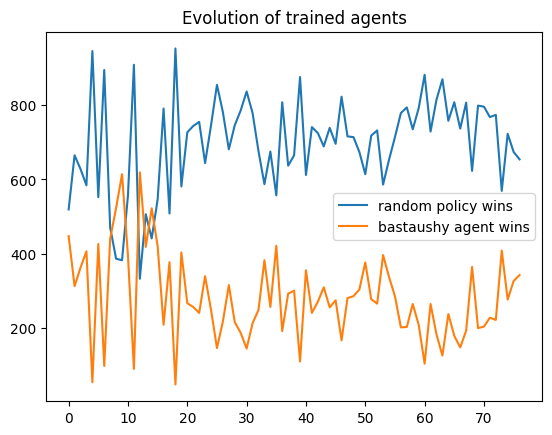

In [13]:
plt.plot(range(len(random_policy_wins)), random_policy_wins, label='random policy wins')

plt.plot(range(len(agent_wins)), agent_wins, label='bastaushy agent wins')

plt.legend()
plt.title("Evolution of trained agents")
plt.show()

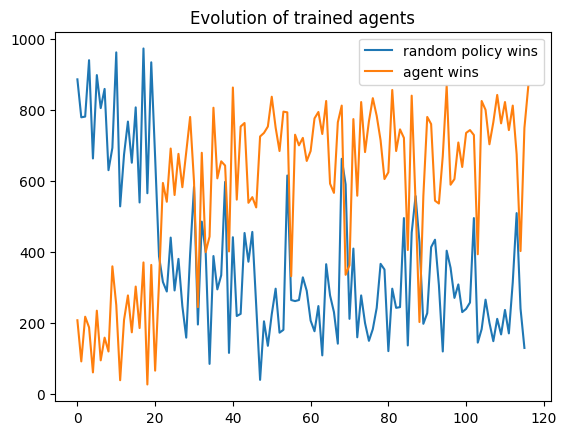

In [17]:
random_policy_wins = [886, 779, 781, 940, 663, 898, 805, 859, 630, 693, 962, 528, 674, 767, 651, 807, 539, 973, 565, 934, 666, 387, 315, 288, 440, 291, 380, 247, 158, 393, 583, 195, 485, 399, 84, 388, 294, 334, 597, 115,
                     441,219,225, 453, 372, 456, 249, 39, 204, 135, 224, 296, 172, 180, 615, 264, 261, 264, 328, 290, 206, 176, 247, 108, 365, 277, 230,
                     141, 662, 590, 211, 409, 159, 277, 199, 149, 182, 242, 366, 350, 120, 296, 242, 244, 495, 136, 454, 557, 427, 197, 227, 413, 434, 306, 119, 403, 355, 270, 308,
                     230, 239, 257, 495, 144, 182, 265, 200, 148, 211, 167, 236, 170, 314, 509, 240, 129]

agent_wins = [207, 91, 217, 187, 60, 234, 94, 158, 119, 359, 250, 38, 208, 277, 173, 302, 185, 370, 26, 363, 65, 314, 594, 541, 691, 560, 676, 582, 681, 780, 598, 244, 679, 399, 443, 806, 607, 655, 643, 401, 863,
             547,753,763,538,554,525,725,735,753,837,750,684,795,793,331,730,700,721,656,684,776,794,732,825,592,566,765,812,335,362,774,558,822,681,768,833,783,714,605,624,856,684,745,721,405,840,539,202,557,780,760,544,536,670,868,589,605,708,
             639, 735, 743, 729, 393, 825, 800, 703, 765, 842, 762, 822, 743, 812, 675, 402, 749, 867]


plt.plot(range(len(random_policy_wins)), random_policy_wins, label='random policy wins')

plt.plot(range(len(agent_wins)), agent_wins, label='agent wins')

plt.legend()
plt.title("Evolution of trained agents")
plt.show()

### 🐈 Plot play results

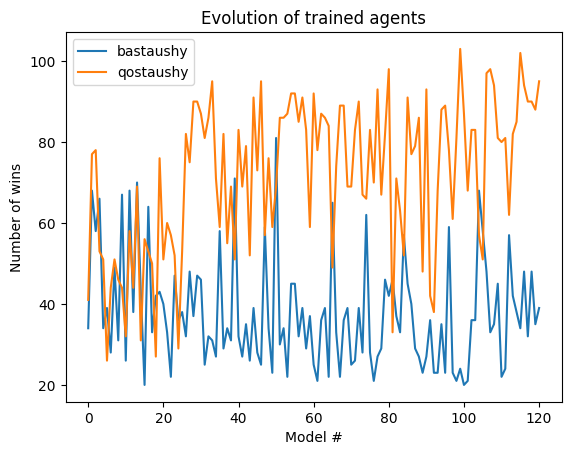

In [15]:
# plt.plot(range(len(num_winners_bastaushy)), num_winners_bastaushy, label="bastaushy")

# plt.plot(range(len(num_winners_qostaushy)), num_winners_qostaushy, label="qostaushy")

# plt.legend()
# plt.xlabel("Model #")
# plt.ylabel("Number of wins")
# plt.title("Evolution of trained agents")
# plt.show()

In [10]:
105/120

0.875

In [18]:
results = []
for key in num_winners_qostaushy.keys():
    results.append(num_winners_qostaushy[key][0])

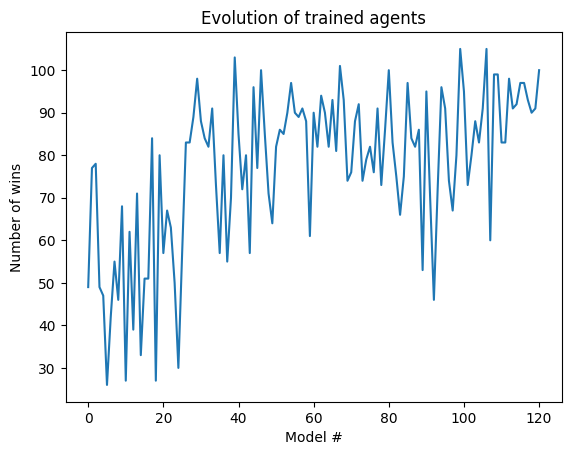

In [19]:
plt.plot(range(len(results)), results, label="qostaushy")

plt.xlabel("Model #")
plt.ylabel("Number of wins")
plt.title("Evolution of trained agents")
plt.show()

# 🐦 Self-play training bastaushy

### 🐊 Load trained agents

In [13]:
agents_learned_bastaushy = []

for model in range(1, 11):
    env = _get_env()
    net = Net(
                state_shape=(22,),
                action_shape=env.action_space.shape or env.action_space.n,
                hidden_sizes=[256, 512, 512, 256],
                device="cuda" if torch.cuda.is_available() else "cpu",
            ).to("cuda" if torch.cuda.is_available() else "cpu")
    
    agent_learned = DQNPolicy(
                model=net,
                optim = torch.optim.Adam(net.parameters(), lr=1e-4),
                discount_factor=0.9,
                estimation_step=3,
                target_update_freq=320,
                action_space=env.action_space
            ).to("cuda" if torch.cuda.is_available() else "cpu")
    
    agent_learned.load_state_dict(torch.load(f"models/bastaushy/policy_dqn_256x512x512x256_{model}.pth"))
    agents_learned_bastaushy.append(agent_learned)

### 🦡 Self-play

In [26]:
count = 0

for i in range(26, 27):
    # random select opponent
    
    agent_opponent_random = random.choice(agents_learned_qostaushy)
    idx = agents_learned_qostaushy.index(agent_opponent_random)
    
    print(f"Train with qostaushy agent_opponent #{idx}")

    # training
    if count == 0:
        agent_learned_bastaushy = copy.deepcopy(random.choice(agents_learned_bastaushy))
        
    next_agent_learned = train_agent_dqn_bastaushy(index=i, agent_learn=agent_learned_bastaushy, agent_opponent=agent_opponent_random, path="bastaushy")
    #add new learned agent
    agents_learned_bastaushy.append(next_agent_learned)
    agent_learned_bastaushy = copy.deepcopy(next_agent_learned)
    count += 1

Train with qostaushy agent_opponent #29


Epoch #1: 1001it [00:02, 461.06it/s, env_step=1000, gradient_step=100, len=0, n/ep=0, n/st=100, rew=0.00]                                                                                         


Epoch #1: test_reward: 10007.600000 ± 4926.469145, best_reward: 11377.600000 ± 3293.052298 in #0


Epoch #2: 1001it [00:02, 416.10it/s, env_step=2000, gradient_step=200, len=0, n/ep=0, n/st=100, rew=0.00]                                                                                         


Epoch #2: test_reward: 12630.400000 ± 2915.180790, best_reward: 12630.400000 ± 2915.180790 in #2


Epoch #3: 1001it [00:01, 511.58it/s, env_step=3000, gradient_step=300, len=0, n/ep=0, n/st=100, rew=0.00]                                                                                         


Epoch #3: test_reward: 9864.500000 ± 4933.825721, best_reward: 12630.400000 ± 2915.180790 in #2


Epoch #4: 1001it [00:02, 413.51it/s, env_step=4000, gradient_step=400, len=0, n/ep=0, n/st=100, rew=0.00]                                                                                         


Epoch #4: test_reward: 15245.200000 ± 3989.771267, best_reward: 15245.200000 ± 3989.771267 in #4


Epoch #5: 1001it [00:02, 499.31it/s, env_step=5000, gradient_step=500, len=0, n/ep=0, n/st=100, rew=0.00]                                                                                         


Epoch #5: test_reward: 11411.400000 ± 3528.710592, best_reward: 15245.200000 ± 3989.771267 in #4


Epoch #6: 1001it [00:02, 462.34it/s, env_step=6000, gradient_step=600, len=0, n/ep=0, n/st=100, rew=0.00]                                                                                         


Epoch #6: test_reward: 7476.000000 ± 3410.030381, best_reward: 15245.200000 ± 3989.771267 in #4


Epoch #7: 1001it [00:02, 443.77it/s, env_step=7000, gradient_step=700, len=0, n/ep=0, n/st=100, rew=0.00]                                                                                         


Epoch #7: test_reward: 6732.400000 ± 3160.446779, best_reward: 15245.200000 ± 3989.771267 in #4


Epoch #8: 1001it [00:02, 479.43it/s, env_step=8000, gradient_step=800, len=0, n/ep=0, n/st=100, rew=0.00]                                                                                         


Epoch #8: test_reward: 6058.200000 ± 2382.176895, best_reward: 15245.200000 ± 3989.771267 in #4


Epoch #9: 1001it [00:02, 378.22it/s, env_step=9000, gradient_step=900, len=0, n/ep=0, n/st=100, rew=0.00]                                                                                         


Epoch #9: test_reward: 3318.400000 ± 2381.469933, best_reward: 15245.200000 ± 3989.771267 in #4


Epoch #10: 1001it [00:02, 431.64it/s, env_step=10000, gradient_step=1000, len=0, n/ep=0, n/st=100, rew=0.00]                                                                                      


Epoch #10: test_reward: 6799.200000 ± 2387.810244, best_reward: 15245.200000 ± 3989.771267 in #4


Epoch #11: 1001it [00:01, 521.30it/s, env_step=11000, gradient_step=1100, len=105, n/ep=0, n/st=100, rew=3354.00]                                                                                 


Epoch #11: test_reward: 2449.500000 ± 1574.042137, best_reward: 15245.200000 ± 3989.771267 in #4


Epoch #12: 1001it [00:02, 446.03it/s, env_step=12000, gradient_step=1200, len=119, n/ep=0, n/st=100, rew=5367.00]                                                                                 


Epoch #12: test_reward: 7494.700000 ± 4132.915752, best_reward: 15245.200000 ± 3989.771267 in #4


Epoch #13: 1001it [00:02, 495.70it/s, env_step=13000, gradient_step=1300, len=125, n/ep=0, n/st=100, rew=5343.00]                                                                                 


Epoch #13: test_reward: 11640.700000 ± 4697.829117, best_reward: 15245.200000 ± 3989.771267 in #4


Epoch #14: 1001it [00:02, 468.76it/s, env_step=14000, gradient_step=1400, len=35, n/ep=1, n/st=100, rew=1183.00]                                                                                  


Epoch #14: test_reward: 9241.500000 ± 3222.975434, best_reward: 15245.200000 ± 3989.771267 in #4


Epoch #15: 1001it [00:02, 382.41it/s, env_step=15000, gradient_step=1500, len=35, n/ep=0, n/st=100, rew=1183.00]                                                                                  


Epoch #15: test_reward: 4245.000000 ± 2530.038933, best_reward: 15245.200000 ± 3989.771267 in #4


Epoch #16: 1001it [00:02, 442.46it/s, env_step=16000, gradient_step=1600, len=156, n/ep=0, n/st=100, rew=7437.00]                                                                                 


Epoch #16: test_reward: 13175.000000 ± 4002.501318, best_reward: 15245.200000 ± 3989.771267 in #4


Epoch #17: 1001it [00:02, 484.52it/s, env_step=17000, gradient_step=1700, len=169, n/ep=0, n/st=100, rew=8269.50]                                                                                 


Epoch #17: test_reward: 11897.800000 ± 7354.188165, best_reward: 15245.200000 ± 3989.771267 in #4


Epoch #18: 1001it [00:02, 416.14it/s, env_step=18000, gradient_step=1800, len=177, n/ep=0, n/st=100, rew=9344.00]                                                                                 


Epoch #18: test_reward: 2619.400000 ± 1601.622190, best_reward: 15245.200000 ± 3989.771267 in #4


Epoch #19: 1001it [00:02, 364.87it/s, env_step=19000, gradient_step=1900, len=189, n/ep=0, n/st=100, rew=10223.00]                                                                                


Epoch #19: test_reward: 10877.500000 ± 5920.420682, best_reward: 15245.200000 ± 3989.771267 in #4


Epoch #20: 1001it [00:02, 405.18it/s, env_step=20000, gradient_step=2000, len=198, n/ep=0, n/st=100, rew=9925.00]                                                                                 


Epoch #20: test_reward: 12648.400000 ± 5523.547976, best_reward: 15245.200000 ± 3989.771267 in #4


Epoch #21: 1001it [00:02, 495.84it/s, env_step=21000, gradient_step=2100, len=207, n/ep=0, n/st=100, rew=10632.00]                                                                                


Epoch #21: test_reward: 12427.500000 ± 5160.146631, best_reward: 15245.200000 ± 3989.771267 in #4


Epoch #22: 1001it [00:02, 466.08it/s, env_step=22000, gradient_step=2200, len=218, n/ep=0, n/st=100, rew=12105.00]                                                                                


Epoch #22: test_reward: 9959.200000 ± 1991.152269, best_reward: 15245.200000 ± 3989.771267 in #4


Epoch #23: 1001it [00:02, 419.75it/s, env_step=23000, gradient_step=2300, len=229, n/ep=0, n/st=100, rew=13197.00]                                                                                


Epoch #23: test_reward: 9365.800000 ± 4984.352351, best_reward: 15245.200000 ± 3989.771267 in #4


Epoch #24: 1001it [00:02, 390.50it/s, env_step=24000, gradient_step=2400, len=233, n/ep=0, n/st=100, rew=13053.00]                                                                                


Epoch #24: test_reward: 17063.200000 ± 3829.718627, best_reward: 17063.200000 ± 3829.718627 in #24


Epoch #25: 1001it [00:02, 466.73it/s, env_step=25000, gradient_step=2500, len=250, n/ep=1, n/st=100, rew=13343.00]                                                                                


Epoch #25: test_reward: 14646.400000 ± 4741.913647, best_reward: 17063.200000 ± 3829.718627 in #24


Epoch #26: 1001it [00:02, 397.51it/s, env_step=26000, gradient_step=2600, len=259, n/ep=0, n/st=100, rew=13944.50]                                                                                


Epoch #26: test_reward: 6476.800000 ± 3341.583242, best_reward: 17063.200000 ± 3829.718627 in #24


Epoch #27: 1001it [00:02, 462.55it/s, env_step=27000, gradient_step=2700, len=269, n/ep=0, n/st=100, rew=15168.00]                                                                                


Epoch #27: test_reward: 9037.400000 ± 2196.164302, best_reward: 17063.200000 ± 3829.718627 in #24


Epoch #28: 1001it [00:02, 374.71it/s, env_step=28000, gradient_step=2800, len=280, n/ep=2, n/st=100, rew=16428.50]                                                                                


Epoch #28: test_reward: 10054.000000 ± 2796.126785, best_reward: 17063.200000 ± 3829.718627 in #24


Epoch #29: 1001it [00:02, 389.77it/s, env_step=29000, gradient_step=2900, len=288, n/ep=0, n/st=100, rew=14580.00]                                                                                


Epoch #29: test_reward: 7069.400000 ± 4695.186305, best_reward: 17063.200000 ± 3829.718627 in #24


Epoch #30: 1001it [00:02, 419.61it/s, env_step=30000, gradient_step=3000, len=296, n/ep=0, n/st=100, rew=15969.50]                                                                                


Epoch #30: test_reward: 9732.600000 ± 2796.020322, best_reward: 17063.200000 ± 3829.718627 in #24


Epoch #31: 1001it [00:02, 383.43it/s, env_step=31000, gradient_step=3100, len=310, n/ep=1, n/st=100, rew=18263.50]                                                                                


Epoch #31: test_reward: 13600.600000 ± 5159.882115, best_reward: 17063.200000 ± 3829.718627 in #24


Epoch #32: 1001it [00:02, 358.58it/s, env_step=32000, gradient_step=3200, len=320, n/ep=1, n/st=100, rew=18795.00]                                                                                


Epoch #32: test_reward: 15676.000000 ± 5290.091417, best_reward: 17063.200000 ± 3829.718627 in #24


Epoch #33: 1001it [00:02, 391.39it/s, env_step=33000, gradient_step=3300, len=328, n/ep=0, n/st=100, rew=19323.50]                                                                                


Epoch #33: test_reward: 13569.000000 ± 5212.920659, best_reward: 17063.200000 ± 3829.718627 in #24


Epoch #34: 1001it [00:02, 426.80it/s, env_step=34000, gradient_step=3400, len=238, n/ep=2, n/st=100, rew=13997.75]                                                                                


Epoch #34: test_reward: 7772.200000 ± 4741.360096, best_reward: 17063.200000 ± 3829.718627 in #24


Epoch #35: 1001it [00:02, 397.38it/s, env_step=35000, gradient_step=3500, len=350, n/ep=1, n/st=100, rew=21731.50]                                                                                


Epoch #35: test_reward: 13037.900000 ± 6098.850850, best_reward: 17063.200000 ± 3829.718627 in #24


Epoch #36: 1001it [00:02, 351.25it/s, env_step=36000, gradient_step=3600, len=233, n/ep=0, n/st=100, rew=12207.00]                                                                                


Epoch #36: test_reward: 12509.200000 ± 6018.456261, best_reward: 17063.200000 ± 3829.718627 in #24


Epoch #37: 1001it [00:03, 331.90it/s, env_step=37000, gradient_step=3700, len=121, n/ep=0, n/st=100, rew=6258.00]                                                                                 


Epoch #37: test_reward: 9872.100000 ± 2985.827438, best_reward: 17063.200000 ± 3829.718627 in #24


Epoch #38: 1001it [00:02, 363.70it/s, env_step=38000, gradient_step=3800, len=201, n/ep=0, n/st=100, rew=11386.00]                                                                                


Epoch #38: test_reward: 12950.500000 ± 4487.144732, best_reward: 17063.200000 ± 3829.718627 in #24


Epoch #39: 1001it [00:02, 343.50it/s, env_step=39000, gradient_step=3900, len=61, n/ep=0, n/st=100, rew=2810.00]                                                                                  


Epoch #39: test_reward: 11585.100000 ± 5286.910297, best_reward: 17063.200000 ± 3829.718627 in #24


Epoch #40: 1001it [00:02, 342.77it/s, env_step=40000, gradient_step=4000, len=400, n/ep=5, n/st=100, rew=24555.20]                                                                                


Epoch #40: test_reward: 6167.500000 ± 2871.814731, best_reward: 17063.200000 ± 3829.718627 in #24


Epoch #41: 1001it [00:02, 334.66it/s, env_step=41000, gradient_step=4100, len=138, n/ep=0, n/st=100, rew=7117.00]                                                                                 


Epoch #41: test_reward: 15316.600000 ± 7893.074701, best_reward: 17063.200000 ± 3829.718627 in #24


Epoch #42: 1001it [00:03, 312.05it/s, env_step=42000, gradient_step=4200, len=135, n/ep=0, n/st=100, rew=5828.50]                                                                                 


Epoch #42: test_reward: 13358.100000 ± 5520.419159, best_reward: 17063.200000 ± 3829.718627 in #24


Epoch #43: 1001it [00:02, 352.76it/s, env_step=43000, gradient_step=4300, len=174, n/ep=1, n/st=100, rew=9903.00]                                                                                 


Epoch #43: test_reward: 12943.400000 ± 6804.532140, best_reward: 17063.200000 ± 3829.718627 in #24


Epoch #44: 1001it [00:02, 422.68it/s, env_step=44000, gradient_step=4400, len=233, n/ep=1, n/st=100, rew=12735.50]                                                                                


Epoch #44: test_reward: 9844.300000 ± 3066.540267, best_reward: 17063.200000 ± 3829.718627 in #24


Epoch #45: 1001it [00:02, 412.39it/s, env_step=45000, gradient_step=4500, len=196, n/ep=0, n/st=100, rew=11888.50]                                                                                


Epoch #45: test_reward: 6753.900000 ± 3016.518107, best_reward: 17063.200000 ± 3829.718627 in #24


Epoch #46: 1001it [00:02, 351.95it/s, env_step=46000, gradient_step=4600, len=189, n/ep=0, n/st=100, rew=8359.00]                                                                                 


Epoch #46: test_reward: 14132.800000 ± 2054.932447, best_reward: 17063.200000 ± 3829.718627 in #24


Epoch #47: 1001it [00:02, 402.68it/s, env_step=47000, gradient_step=4700, len=205, n/ep=0, n/st=100, rew=10581.00]                                                                                


Epoch #47: test_reward: 14768.700000 ± 4587.859262, best_reward: 17063.200000 ± 3829.718627 in #24


Epoch #48: 1001it [00:02, 392.05it/s, env_step=48000, gradient_step=4800, len=164, n/ep=2, n/st=100, rew=8398.50]                                                                                 


Epoch #48: test_reward: 18442.400000 ± 5267.454304, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #49: 1001it [00:02, 414.58it/s, env_step=49000, gradient_step=4900, len=202, n/ep=1, n/st=100, rew=11152.00]                                                                                


Epoch #49: test_reward: 14751.400000 ± 6691.628250, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #50: 1001it [00:02, 405.65it/s, env_step=50000, gradient_step=5000, len=203, n/ep=0, n/st=100, rew=12370.00]                                                                                


Epoch #50: test_reward: 11440.000000 ± 2998.181449, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #51: 1001it [00:02, 398.32it/s, env_step=51000, gradient_step=5100, len=254, n/ep=1, n/st=100, rew=15614.00]                                                                                


Epoch #51: test_reward: 13095.000000 ± 4955.562672, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #52: 1001it [00:02, 344.49it/s, env_step=52000, gradient_step=5200, len=155, n/ep=1, n/st=100, rew=9272.50]                                                                                 


Epoch #52: test_reward: 11795.000000 ± 2308.565312, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #53: 1001it [00:02, 381.90it/s, env_step=53000, gradient_step=5300, len=238, n/ep=1, n/st=100, rew=14185.00]                                                                                


Epoch #53: test_reward: 12155.800000 ± 3233.638502, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #54: 1001it [00:02, 363.73it/s, env_step=54000, gradient_step=5400, len=216, n/ep=3, n/st=100, rew=12765.00]                                                                                


Epoch #54: test_reward: 12899.000000 ± 4331.483510, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #55: 1001it [00:02, 445.90it/s, env_step=55000, gradient_step=5500, len=185, n/ep=0, n/st=100, rew=10632.75]                                                                                


Epoch #55: test_reward: 14776.800000 ± 5844.608966, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #56: 1001it [00:02, 392.59it/s, env_step=56000, gradient_step=5600, len=89, n/ep=1, n/st=100, rew=4208.00]                                                                                  


Epoch #56: test_reward: 13697.900000 ± 4659.087860, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #57: 1001it [00:02, 385.14it/s, env_step=57000, gradient_step=5700, len=106, n/ep=0, n/st=100, rew=5870.00]                                                                                 


Epoch #57: test_reward: 15427.500000 ± 3799.169337, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #58: 1001it [00:02, 409.19it/s, env_step=58000, gradient_step=5800, len=133, n/ep=1, n/st=100, rew=6846.50]                                                                                 


Epoch #58: test_reward: 8072.000000 ± 2813.586039, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #59: 1001it [00:02, 381.77it/s, env_step=59000, gradient_step=5900, len=326, n/ep=1, n/st=100, rew=21342.00]                                                                                


Epoch #59: test_reward: 14747.800000 ± 5397.018136, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #60: 1001it [00:02, 362.02it/s, env_step=60000, gradient_step=6000, len=154, n/ep=0, n/st=100, rew=9139.75]                                                                                 


Epoch #60: test_reward: 11620.500000 ± 5650.467171, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #61: 1001it [00:02, 459.39it/s, env_step=61000, gradient_step=6100, len=173, n/ep=0, n/st=100, rew=9504.75]                                                                                 


Epoch #61: test_reward: 15041.700000 ± 3170.766502, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #62: 1001it [00:02, 410.02it/s, env_step=62000, gradient_step=6200, len=339, n/ep=0, n/st=100, rew=21597.00]                                                                                


Epoch #62: test_reward: 17673.900000 ± 7064.385571, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #63: 1001it [00:02, 397.73it/s, env_step=63000, gradient_step=6300, len=190, n/ep=1, n/st=100, rew=8832.00]                                                                                 


Epoch #63: test_reward: 9586.300000 ± 5243.579828, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #64: 1001it [00:02, 445.05it/s, env_step=64000, gradient_step=6400, len=223, n/ep=0, n/st=100, rew=13199.50]                                                                                


Epoch #64: test_reward: 11464.000000 ± 5102.816869, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #65: 1001it [00:02, 440.23it/s, env_step=65000, gradient_step=6500, len=218, n/ep=0, n/st=100, rew=11517.00]                                                                                


Epoch #65: test_reward: 10771.400000 ± 4999.381886, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #66: 1001it [00:02, 389.88it/s, env_step=66000, gradient_step=6600, len=163, n/ep=1, n/st=100, rew=9469.00]                                                                                 


Epoch #66: test_reward: 17624.500000 ± 5307.078787, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #67: 1001it [00:02, 426.23it/s, env_step=67000, gradient_step=6700, len=215, n/ep=1, n/st=100, rew=12720.50]                                                                                


Epoch #67: test_reward: 14552.400000 ± 3234.398343, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #68: 1001it [00:02, 415.31it/s, env_step=68000, gradient_step=6800, len=198, n/ep=1, n/st=100, rew=8805.00]                                                                                 


Epoch #68: test_reward: 13541.700000 ± 5097.963006, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #69: 1001it [00:02, 374.03it/s, env_step=69000, gradient_step=6900, len=207, n/ep=0, n/st=100, rew=10718.00]                                                                                


Epoch #69: test_reward: 10727.300000 ± 3692.576879, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #70: 1001it [00:02, 347.65it/s, env_step=70000, gradient_step=7000, len=76, n/ep=1, n/st=100, rew=3063.50]                                                                                  


Epoch #70: test_reward: 13970.800000 ± 3848.172886, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #71: 1001it [00:02, 421.82it/s, env_step=71000, gradient_step=7100, len=117, n/ep=0, n/st=100, rew=5889.00]                                                                                 


Epoch #71: test_reward: 10982.900000 ± 5393.641635, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #72: 1001it [00:02, 394.94it/s, env_step=72000, gradient_step=7200, len=207, n/ep=0, n/st=100, rew=11704.67]                                                                                


Epoch #72: test_reward: 12660.400000 ± 6123.362593, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #73: 1001it [00:02, 418.41it/s, env_step=73000, gradient_step=7300, len=98, n/ep=0, n/st=100, rew=5162.00]                                                                                  


Epoch #73: test_reward: 14101.700000 ± 5212.973548, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #74: 1001it [00:02, 401.50it/s, env_step=74000, gradient_step=7400, len=198, n/ep=0, n/st=100, rew=12486.50]                                                                                


Epoch #74: test_reward: 14852.900000 ± 6029.205212, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #75: 1001it [00:02, 397.72it/s, env_step=75000, gradient_step=7500, len=155, n/ep=1, n/st=100, rew=8809.00]                                                                                 


Epoch #75: test_reward: 9923.600000 ± 3498.080479, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #76: 1001it [00:02, 430.37it/s, env_step=76000, gradient_step=7600, len=175, n/ep=0, n/st=100, rew=10715.50]                                                                                


Epoch #76: test_reward: 9633.200000 ± 5163.929992, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #77: 1001it [00:02, 408.03it/s, env_step=77000, gradient_step=7700, len=79, n/ep=0, n/st=100, rew=2691.00]                                                                                  


Epoch #77: test_reward: 9273.700000 ± 4920.676662, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #78: 1001it [00:02, 353.23it/s, env_step=78000, gradient_step=7800, len=141, n/ep=1, n/st=100, rew=8443.00]                                                                                 


Epoch #78: test_reward: 10601.200000 ± 5046.355453, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #79: 1001it [00:02, 417.46it/s, env_step=79000, gradient_step=7900, len=169, n/ep=0, n/st=100, rew=9828.50]                                                                                 


Epoch #79: test_reward: 11694.500000 ± 6765.834660, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #80: 1001it [00:02, 401.81it/s, env_step=80000, gradient_step=8000, len=142, n/ep=0, n/st=100, rew=7101.00]                                                                                 


Epoch #80: test_reward: 7751.000000 ± 4073.233531, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #81: 1001it [00:02, 349.92it/s, env_step=81000, gradient_step=8100, len=346, n/ep=0, n/st=100, rew=21965.00]                                                                                


Epoch #81: test_reward: 12100.500000 ± 5589.210879, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #82: 1001it [00:02, 353.96it/s, env_step=82000, gradient_step=8200, len=130, n/ep=0, n/st=100, rew=6585.00]                                                                                 


Epoch #82: test_reward: 12827.000000 ± 2930.141976, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #83: 1001it [00:02, 442.38it/s, env_step=83000, gradient_step=8300, len=179, n/ep=1, n/st=100, rew=7435.00]                                                                                 


Epoch #83: test_reward: 14894.000000 ± 4451.335418, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #84: 1001it [00:03, 331.89it/s, env_step=84000, gradient_step=8400, len=133, n/ep=0, n/st=100, rew=6544.00]                                                                                 


Epoch #84: test_reward: 9558.400000 ± 2917.309418, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #85: 1001it [00:03, 322.63it/s, env_step=85000, gradient_step=8500, len=189, n/ep=0, n/st=100, rew=10939.67]                                                                                


Epoch #85: test_reward: 10633.400000 ± 2140.176824, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #86: 1001it [00:03, 331.58it/s, env_step=86000, gradient_step=8600, len=228, n/ep=0, n/st=100, rew=12924.00]                                                                                


Epoch #86: test_reward: 11840.900000 ± 6541.968273, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #87: 1001it [00:02, 356.10it/s, env_step=87000, gradient_step=8700, len=207, n/ep=0, n/st=100, rew=11978.00]                                                                                


Epoch #87: test_reward: 9944.200000 ± 2253.256745, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #88: 1001it [00:02, 415.64it/s, env_step=88000, gradient_step=8800, len=131, n/ep=1, n/st=100, rew=6472.00]                                                                                 


Epoch #88: test_reward: 9208.000000 ± 3379.897750, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #89: 1001it [00:02, 401.13it/s, env_step=89000, gradient_step=8900, len=301, n/ep=1, n/st=100, rew=19154.00]                                                                                


Epoch #89: test_reward: 14179.000000 ± 5976.772055, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #90: 1001it [00:02, 411.72it/s, env_step=90000, gradient_step=9000, len=330, n/ep=0, n/st=100, rew=21270.00]                                                                                


Epoch #90: test_reward: 14110.200000 ± 2685.219462, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #91: 1001it [00:02, 415.51it/s, env_step=91000, gradient_step=9100, len=83, n/ep=0, n/st=100, rew=4861.00]                                                                                  


Epoch #91: test_reward: 8306.100000 ± 8563.309039, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #92: 1001it [00:02, 410.82it/s, env_step=92000, gradient_step=9200, len=175, n/ep=1, n/st=100, rew=10472.50]                                                                                


Epoch #92: test_reward: 17145.200000 ± 6418.773602, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #93: 1001it [00:03, 322.28it/s, env_step=93000, gradient_step=9300, len=213, n/ep=1, n/st=100, rew=13404.50]                                                                                


Epoch #93: test_reward: 12542.500000 ± 3969.681429, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #94: 1001it [00:02, 420.86it/s, env_step=94000, gradient_step=9400, len=277, n/ep=0, n/st=100, rew=16857.00]                                                                                


Epoch #94: test_reward: 7537.100000 ± 2553.849348, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #95: 1001it [00:02, 395.16it/s, env_step=95000, gradient_step=9500, len=205, n/ep=1, n/st=100, rew=12646.00]                                                                                


Epoch #95: test_reward: 18092.600000 ± 4594.630958, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #96: 1001it [00:02, 426.94it/s, env_step=96000, gradient_step=9600, len=161, n/ep=0, n/st=100, rew=9603.12]                                                                                 


Epoch #96: test_reward: 9127.200000 ± 2396.319044, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #97: 1001it [00:02, 407.51it/s, env_step=97000, gradient_step=9700, len=243, n/ep=0, n/st=100, rew=13315.00]                                                                                


Epoch #97: test_reward: 18194.200000 ± 5752.907522, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #98: 1001it [00:02, 350.83it/s, env_step=98000, gradient_step=9800, len=271, n/ep=0, n/st=100, rew=15956.50]                                                                                


Epoch #98: test_reward: 14115.000000 ± 3159.378895, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #99: 1001it [00:02, 432.37it/s, env_step=99000, gradient_step=9900, len=82, n/ep=0, n/st=100, rew=3603.00]                                                                                  


Epoch #99: test_reward: 13895.100000 ± 4758.043935, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #100: 1001it [00:02, 361.03it/s, env_step=100000, gradient_step=10000, len=345, n/ep=1, n/st=100, rew=21752.00]                                                                             


Epoch #100: test_reward: 13830.400000 ± 5027.205490, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #101: 1001it [00:02, 351.42it/s, env_step=101000, gradient_step=10100, len=161, n/ep=0, n/st=100, rew=9174.00]                                                                              


Epoch #101: test_reward: 15032.300000 ± 4459.481630, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #102: 1001it [00:02, 413.24it/s, env_step=102000, gradient_step=10200, len=379, n/ep=0, n/st=100, rew=25683.00]                                                                             


Epoch #102: test_reward: 16234.600000 ± 5173.767973, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #103: 1001it [00:02, 432.40it/s, env_step=103000, gradient_step=10300, len=249, n/ep=1, n/st=100, rew=16264.50]                                                                             


Epoch #103: test_reward: 8026.100000 ± 2987.927457, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #104: 1001it [00:02, 364.17it/s, env_step=104000, gradient_step=10400, len=186, n/ep=0, n/st=100, rew=10443.25]                                                                             


Epoch #104: test_reward: 13347.400000 ± 3342.653443, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #105: 1001it [00:02, 409.11it/s, env_step=105000, gradient_step=10500, len=184, n/ep=0, n/st=100, rew=10990.00]                                                                             


Epoch #105: test_reward: 13270.600000 ± 4951.849517, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #106: 1001it [00:02, 415.97it/s, env_step=106000, gradient_step=10600, len=188, n/ep=1, n/st=100, rew=11922.00]                                                                             


Epoch #106: test_reward: 8360.700000 ± 1624.399584, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #107: 1001it [00:02, 425.66it/s, env_step=107000, gradient_step=10700, len=139, n/ep=0, n/st=100, rew=8305.00]                                                                              


Epoch #107: test_reward: 8563.200000 ± 4616.881302, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #108: 1001it [00:02, 411.29it/s, env_step=108000, gradient_step=10800, len=400, n/ep=1, n/st=100, rew=24855.00]                                                                             


Epoch #108: test_reward: 18149.400000 ± 6607.655624, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #109: 1001it [00:02, 423.49it/s, env_step=109000, gradient_step=10900, len=186, n/ep=0, n/st=100, rew=9349.00]                                                                              


Epoch #109: test_reward: 9819.500000 ± 3271.143141, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #110: 1001it [00:03, 317.08it/s, env_step=110000, gradient_step=11000, len=225, n/ep=3, n/st=100, rew=13796.83]                                                                             


Epoch #110: test_reward: 17365.400000 ± 5804.427417, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #111: 1001it [00:02, 335.15it/s, env_step=111000, gradient_step=11100, len=152, n/ep=2, n/st=100, rew=8754.50]                                                                              


Epoch #111: test_reward: 14254.700000 ± 5613.504361, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #112: 1001it [00:03, 326.28it/s, env_step=112000, gradient_step=11200, len=119, n/ep=0, n/st=100, rew=7072.50]                                                                              


Epoch #112: test_reward: 14725.300000 ± 4878.223284, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #113: 1001it [00:02, 426.32it/s, env_step=113000, gradient_step=11300, len=91, n/ep=0, n/st=100, rew=4940.50]                                                                               


Epoch #113: test_reward: 11010.300000 ± 3031.001552, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #114: 1001it [00:02, 340.47it/s, env_step=114000, gradient_step=11400, len=214, n/ep=0, n/st=100, rew=12181.00]                                                                             


Epoch #114: test_reward: 16340.700000 ± 3091.477448, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #115: 1001it [00:02, 358.52it/s, env_step=115000, gradient_step=11500, len=235, n/ep=1, n/st=100, rew=13607.00]                                                                             


Epoch #115: test_reward: 15586.300000 ± 6700.131776, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #116: 1001it [00:02, 355.88it/s, env_step=116000, gradient_step=11600, len=195, n/ep=1, n/st=100, rew=11489.00]                                                                             


Epoch #116: test_reward: 11027.400000 ± 4954.081150, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #117: 1001it [00:02, 340.53it/s, env_step=117000, gradient_step=11700, len=157, n/ep=0, n/st=100, rew=8459.00]                                                                              


Epoch #117: test_reward: 17381.900000 ± 6577.245753, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #118: 1001it [00:02, 341.42it/s, env_step=118000, gradient_step=11800, len=192, n/ep=0, n/st=100, rew=11957.00]                                                                             


Epoch #118: test_reward: 14875.900000 ± 4096.015612, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #119: 1001it [00:02, 359.07it/s, env_step=119000, gradient_step=11900, len=144, n/ep=0, n/st=100, rew=7921.75]                                                                              


Epoch #119: test_reward: 10407.000000 ± 1762.077921, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #120: 1001it [00:02, 370.66it/s, env_step=120000, gradient_step=12000, len=155, n/ep=1, n/st=100, rew=9305.00]                                                                              


Epoch #120: test_reward: 12217.600000 ± 3500.321448, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #121: 1001it [00:02, 426.02it/s, env_step=121000, gradient_step=12100, len=197, n/ep=1, n/st=100, rew=11391.00]                                                                             


Epoch #121: test_reward: 7452.600000 ± 3501.184948, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #122: 1001it [00:02, 363.57it/s, env_step=122000, gradient_step=12200, len=128, n/ep=0, n/st=100, rew=6276.50]                                                                              


Epoch #122: test_reward: 14318.400000 ± 4112.051050, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #123: 1001it [00:02, 415.46it/s, env_step=123000, gradient_step=12300, len=238, n/ep=0, n/st=100, rew=15514.50]                                                                             


Epoch #123: test_reward: 10627.400000 ± 4033.449174, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #124: 1001it [00:03, 333.23it/s, env_step=124000, gradient_step=12400, len=174, n/ep=1, n/st=100, rew=10315.00]                                                                             


Epoch #124: test_reward: 14345.100000 ± 5902.272773, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #125: 1001it [00:02, 362.26it/s, env_step=125000, gradient_step=12500, len=143, n/ep=0, n/st=100, rew=7963.50]                                                                              


Epoch #125: test_reward: 15533.400000 ± 4324.237764, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #126: 1001it [00:02, 378.68it/s, env_step=126000, gradient_step=12600, len=172, n/ep=0, n/st=100, rew=10372.50]                                                                             


Epoch #126: test_reward: 6802.300000 ± 3767.248493, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #127: 1001it [00:02, 426.47it/s, env_step=127000, gradient_step=12700, len=123, n/ep=0, n/st=100, rew=6668.00]                                                                              


Epoch #127: test_reward: 10901.200000 ± 4150.595061, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #128: 1001it [00:02, 361.02it/s, env_step=128000, gradient_step=12800, len=132, n/ep=0, n/st=100, rew=7449.00]                                                                              


Epoch #128: test_reward: 11115.200000 ± 2826.533028, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #129: 1001it [00:02, 349.07it/s, env_step=129000, gradient_step=12900, len=236, n/ep=0, n/st=100, rew=15640.50]                                                                             


Epoch #129: test_reward: 15903.100000 ± 5321.874434, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #130: 1001it [00:02, 380.96it/s, env_step=130000, gradient_step=13000, len=248, n/ep=1, n/st=100, rew=14452.00]                                                                             


Epoch #130: test_reward: 12281.100000 ± 3935.091192, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #131: 1001it [00:02, 423.16it/s, env_step=131000, gradient_step=13100, len=246, n/ep=1, n/st=100, rew=15164.50]                                                                             


Epoch #131: test_reward: 5349.600000 ± 3214.661139, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #132: 1001it [00:02, 412.60it/s, env_step=132000, gradient_step=13200, len=182, n/ep=0, n/st=100, rew=10969.50]                                                                             


Epoch #132: test_reward: 10768.400000 ± 3804.731560, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #133: 1001it [00:02, 411.14it/s, env_step=133000, gradient_step=13300, len=143, n/ep=0, n/st=100, rew=8129.50]                                                                              


Epoch #133: test_reward: 8767.200000 ± 1457.079600, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #134: 1001it [00:02, 378.06it/s, env_step=134000, gradient_step=13400, len=213, n/ep=0, n/st=100, rew=13004.00]                                                                             


Epoch #134: test_reward: 8091.600000 ± 3977.431714, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #135: 1001it [00:02, 351.55it/s, env_step=135000, gradient_step=13500, len=258, n/ep=0, n/st=100, rew=16462.00]                                                                             


Epoch #135: test_reward: 13432.000000 ± 5815.945804, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #136: 1001it [00:02, 394.68it/s, env_step=136000, gradient_step=13600, len=153, n/ep=0, n/st=100, rew=9340.00]                                                                              


Epoch #136: test_reward: 9103.800000 ± 2870.420938, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #137: 1001it [00:03, 316.84it/s, env_step=137000, gradient_step=13700, len=212, n/ep=1, n/st=100, rew=13341.00]                                                                             


Epoch #137: test_reward: 11640.000000 ± 3004.302648, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #138: 1001it [00:02, 423.88it/s, env_step=138000, gradient_step=13800, len=135, n/ep=0, n/st=100, rew=8327.00]                                                                              


Epoch #138: test_reward: 13666.500000 ± 3711.363126, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #139: 1001it [00:02, 347.71it/s, env_step=139000, gradient_step=13900, len=144, n/ep=0, n/st=100, rew=8727.00]                                                                              


Epoch #139: test_reward: 9318.800000 ± 2931.973288, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #140: 1001it [00:02, 368.99it/s, env_step=140000, gradient_step=14000, len=63, n/ep=0, n/st=100, rew=3004.00]                                                                               


Epoch #140: test_reward: 11973.600000 ± 4267.924723, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #141: 1001it [00:02, 353.59it/s, env_step=141000, gradient_step=14100, len=195, n/ep=0, n/st=100, rew=10386.00]                                                                             


Epoch #141: test_reward: 8353.100000 ± 4199.989773, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #142: 1001it [00:02, 363.42it/s, env_step=142000, gradient_step=14200, len=164, n/ep=1, n/st=100, rew=10243.00]                                                                             


Epoch #142: test_reward: 9721.300000 ± 3433.586435, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #143: 1001it [00:02, 371.47it/s, env_step=143000, gradient_step=14300, len=203, n/ep=0, n/st=100, rew=12418.00]                                                                             


Epoch #143: test_reward: 13401.300000 ± 4658.433515, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #144: 1001it [00:02, 419.96it/s, env_step=144000, gradient_step=14400, len=159, n/ep=0, n/st=100, rew=9792.50]                                                                              


Epoch #144: test_reward: 9470.200000 ± 2659.562137, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #145: 1001it [00:02, 347.07it/s, env_step=145000, gradient_step=14500, len=176, n/ep=2, n/st=100, rew=10472.75]                                                                             


Epoch #145: test_reward: 11313.400000 ± 5330.791765, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #146: 1001it [00:02, 369.05it/s, env_step=146000, gradient_step=14600, len=139, n/ep=2, n/st=100, rew=8317.00]                                                                              


Epoch #146: test_reward: 13476.000000 ± 3610.815642, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #147: 1001it [00:02, 360.59it/s, env_step=147000, gradient_step=14700, len=272, n/ep=1, n/st=100, rew=17631.50]                                                                             


Epoch #147: test_reward: 14653.600000 ± 4884.855683, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #148: 1001it [00:03, 332.79it/s, env_step=148000, gradient_step=14800, len=181, n/ep=1, n/st=100, rew=10506.00]                                                                             


Epoch #148: test_reward: 16252.200000 ± 5837.953919, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #149: 1001it [00:02, 372.91it/s, env_step=149000, gradient_step=14900, len=97, n/ep=0, n/st=100, rew=4889.00]                                                                               


Epoch #149: test_reward: 11256.800000 ± 3864.680189, best_reward: 18442.400000 ± 5267.454304 in #48


Epoch #150: 1001it [00:02, 377.86it/s, env_step=150000, gradient_step=15000, len=161, n/ep=0, n/st=100, rew=8644.00]                                                                              


Epoch #150: test_reward: 10367.400000 ± 2938.508914, best_reward: 18442.400000 ± 5267.454304 in #48

==========Result==========
InfoStats(gradient_step=15000, best_reward=18442.4, best_reward_std=5267.454303551195, train_step=150000, train_episode=708, test_step=333576, test_episode=1510, timing=TimingStats(total_time=609.6570348739624, train_time=386.70710349082947, train_time_collect=58.04313540458679, train_time_update=321.59069442749023, test_time=222.94993138313293, update_speed=387.8904696757327))

(the trained policy can be accessed via policy.policies[agents[0]])


### 🦃 Play all policies with random policy

In [28]:
random_policy_wins = []
agent_wins = []

for model in range(26, 27):
    
    PLAYS = {"bastaushy": 0, "qostaushy": 0}

    env = _get_env()#render_mode="human")
    net = Net(
                state_shape=(22,),
                action_shape=env.action_space.shape or env.action_space.n,
                hidden_sizes=[256, 512, 512, 256],
                device="cuda" if torch.cuda.is_available() else "cpu",
            ).to("cuda" if torch.cuda.is_available() else "cpu")
    
    agent_learned = DQNPolicy(
                model=net,
                optim = torch.optim.Adam(net.parameters(), lr=1e-4),
                discount_factor=0.9,
                estimation_step=3,
                target_update_freq=320,
                action_space=env.action_space
            ).to("cuda" if torch.cuda.is_available() else "cpu")
    
    agent_learned.load_state_dict(torch.load(f"models/bastaushy/policy_dqn_256x512x512x256_{model}.pth"))
    
    policies = MultiAgentPolicyManager(policies=[agent_learned, RandomPolicy(action_space=env.action_space)], env=env)
    
    env = DummyVectorEnv([lambda: env])
    
    collector = Collector(policies, env)
    
    result = collector.collect(n_episode=100, reset_before_collect=True)
    random_policy_wins.append(PLAYS['qostaushy'])
    agent_wins.append(PLAYS['bastaushy'])
    print(f"Agent #{model} plays as bastaushy, result: {PLAYS}")

KeyboardInterrupt: 

In [20]:
for model in range(27, 51):
    
    PLAYS = {"bastaushy": 0, "qostaushy": 0}

    env = _get_env()#render_mode="human")
    net = Net(
                state_shape=(22,),
                action_shape=env.action_space.shape or env.action_space.n,
                hidden_sizes=[256, 512, 512, 256],
                device="cuda" if torch.cuda.is_available() else "cpu",
            ).to("cuda" if torch.cuda.is_available() else "cpu")
    
    agent_learned = DQNPolicy(
                model=net,
                optim = torch.optim.Adam(net.parameters(), lr=1e-4),
                discount_factor=0.9,
                estimation_step=3,
                target_update_freq=320,
                action_space=env.action_space
            ).to("cuda" if torch.cuda.is_available() else "cpu")
    
    agent_learned.load_state_dict(torch.load(f"models/bastaushy/policy_dqn_256x512x512x256_{model}.pth"))
    
    policies = MultiAgentPolicyManager(policies=[agent_learned, RandomPolicy(action_space=env.action_space)], env=env)
    
    env = DummyVectorEnv([lambda: env])
    
    collector = Collector(policies, env)
    
    result = collector.collect(n_episode=100, reset_before_collect=True)
    random_policy_wins.append(PLAYS['qostaushy'])
    agent_wins.append(PLAYS['bastaushy'])
    print(f"Agent #{model} plays as bastaushy, result: {PLAYS}")

Agent #27 plays as bastaushy, result: {'bastaushy': 42, 'qostaushy': 57}
Agent #28 plays as bastaushy, result: {'bastaushy': 19, 'qostaushy': 69}
Agent #29 plays as bastaushy, result: {'bastaushy': 56, 'qostaushy': 41}
Agent #30 plays as bastaushy, result: {'bastaushy': 71, 'qostaushy': 25}
Agent #31 plays as bastaushy, result: {'bastaushy': 50, 'qostaushy': 43}
Agent #32 plays as bastaushy, result: {'bastaushy': 38, 'qostaushy': 54}
Agent #33 plays as bastaushy, result: {'bastaushy': 40, 'qostaushy': 49}
Agent #34 plays as bastaushy, result: {'bastaushy': 17, 'qostaushy': 64}
Agent #35 plays as bastaushy, result: {'bastaushy': 36, 'qostaushy': 46}
Agent #36 plays as bastaushy, result: {'bastaushy': 63, 'qostaushy': 32}
Agent #37 plays as bastaushy, result: {'bastaushy': 56, 'qostaushy': 27}
Agent #38 plays as bastaushy, result: {'bastaushy': 52, 'qostaushy': 37}
Agent #39 plays as bastaushy, result: {'bastaushy': 48, 'qostaushy': 36}
Agent #40 plays as bastaushy, result: {'bastaushy':

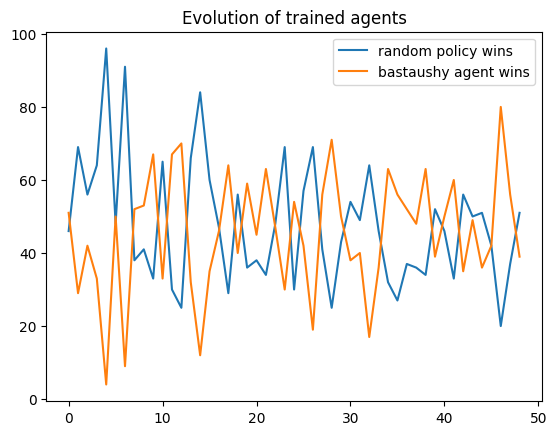

In [21]:
plt.plot(range(len(random_policy_wins)), random_policy_wins, label='random policy wins')

plt.plot(range(len(agent_wins)), agent_wins, label='bastaushy agent wins')

plt.legend()
plt.title("Evolution of trained agents")
plt.show()

## 🐩 Play different learned policies

In [22]:
num_winners_bastaushy = {key: [] for key in range(len(agents_learned_bastaushy))}
num_winners_qostaushy = {key: [] for key in range(len(agents_learned_qostaushy))}

for n_agent_opp, agent_opponent in enumerate(agents_learned_qostaushy):

    print("----------------------------------------------------")
    b_winners = 0
    q_winners = 0
    for n_agent, agent in enumerate(agents_learned_bastaushy):
        PLAYS = {"bastaushy": 0, "qostaushy": 0}

        env = _get_env()#render_mode="human")

        policies = MultiAgentPolicyManager(policies=[agent, agent_opponent], env=env)
        env = DummyVectorEnv([lambda: env])
        
        collector = Collector(policies, env, exploration_noise=False)
        
        result = collector.collect(n_episode=1, reset_before_collect=True)

        #b_winners += PLAYS["bastaushy"]
        q_winners += PLAYS["qostaushy"]
            
    #print(f"Agent #{n_agent} wins as bastaushy {b_winners} times")
    print(f"Agent #{n_agent_opp} wins as qostaushy {q_winners} times")
    
    #num_winners_bastaushy[n_agent].append(b_winners)
    num_winners_qostaushy[n_agent_opp].append(q_winners)

----------------------------------------------------
Agent #0 wins as qostaushy 17 times
----------------------------------------------------
Agent #1 wins as qostaushy 20 times
----------------------------------------------------
Agent #2 wins as qostaushy 22 times
----------------------------------------------------
Agent #3 wins as qostaushy 13 times
----------------------------------------------------
Agent #4 wins as qostaushy 14 times
----------------------------------------------------
Agent #5 wins as qostaushy 7 times
----------------------------------------------------
Agent #6 wins as qostaushy 24 times
----------------------------------------------------
Agent #7 wins as qostaushy 15 times
----------------------------------------------------
Agent #8 wins as qostaushy 15 times
----------------------------------------------------
Agent #9 wins as qostaushy 16 times
----------------------------------------------------
Agent #10 wins as qostaushy 17 times
---------------------

### 🐧 Plot play results

In [23]:
results_qostaushy = []

for key in num_winners_qostaushy.keys():
    results_qostaushy.append(num_winners_qostaushy[key][0])

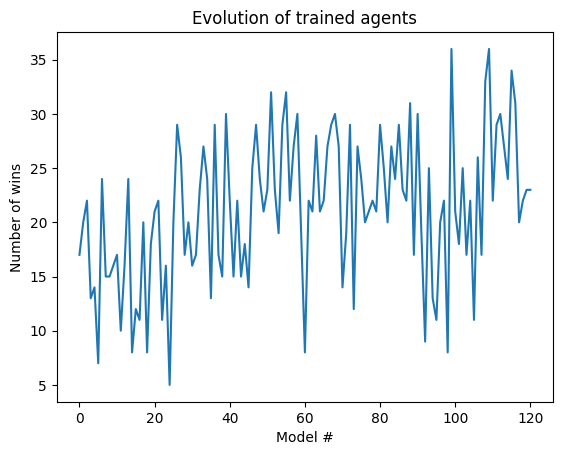

In [25]:
plt.plot(range(len(results_qostaushy)), results_qostaushy, label="qostaushy")

plt.xlabel("Model #")
plt.ylabel("Number of wins")
plt.title("Evolution of trained agents")
plt.show()